In [1]:
# Needed Packages

In [1]:
## test
import pandas as pd

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

# Time Series Libaries
from statsmodels.tsa.ar_model import AR
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import lag_plot
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

#Useful stuff
import scipy
import datetime as dt
import numpy as np
from pandas import concat


# Error Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline  

from pandas.plotting import autocorrelation_plot
#s


C:\Users\hornd\AppData\Local\R-MINI~1\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\hornd\AppData\Local\R-MINI~1\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\hornd\AppData\Local\R-MINI~1\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
print("Git changes")

Git changes


In [3]:
#ita_df = pd.read_csv("Sea arrivals by day_ITA.csv", sep = ";", index_col=0,parse_dates=True, header=0,dayfirst=True)
ita_df = pd.read_csv("Sea arrivals by day2.csv", sep = ";", index_col=0,parse_dates=True, header=0,dayfirst=True)
#ita_df = pd.read_csv("Sea arrivals by day_ITA.csv", sep = ";", header=0)

# Data loading and first explorations

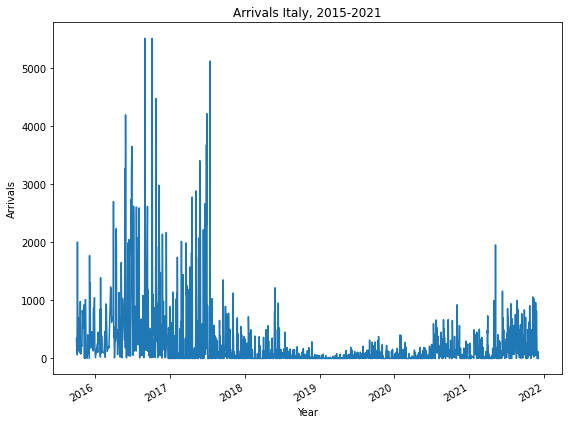

In [4]:
fig, ax = plt.subplots(figsize=(8,6));

ita_df['individuals'].plot(ax=ax);

ax.set_title('Arrivals Italy, 2015-2021');
ax.set_ylabel('Arrivals');
ax.set_xlabel('Year');
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout()

In [5]:
# Plotting of relevant Acf pacf Data to determine the Order of the SARIMA and Arima Modell
def tsplot(y, lags=None, title='', figsize=(14, 8)):

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    plot_acf(y, lags=lags, ax=acf_ax)
    plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

(<AxesSubplot:title={'center':'Arrivals of individuals in Italy'}, xlabel='Date'>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

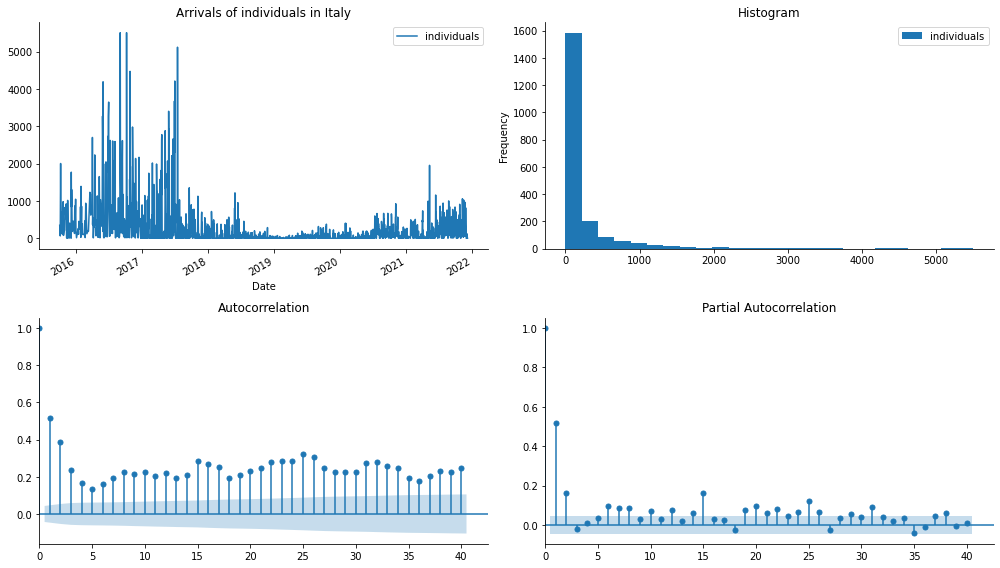

In [6]:
tsplot(ita_df, title="Arrivals of individuals in Italy",lags=40)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

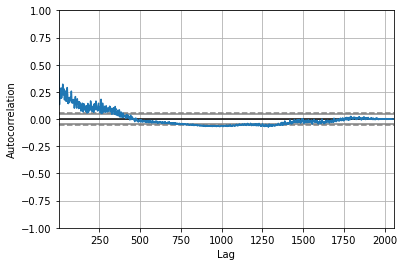

In [7]:
autocorrelation_plot(ita_df)

In [8]:
#ita_ln_diff.isna().sum()
#ita_df["individuals"] = ita_df["individuals"].fillna(0)
ita_df["individuals"].isnull().sum()
ita_df.max()

individuals    5504
dtype: int64

In [9]:
type(ita_df)

pandas.core.frame.DataFrame

In [10]:
ita_df.head()

,individuals
Date,
2015-10-01,343
2015-10-03,128
2015-10-04,62
2015-10-06,2001
2015-10-07,1010


In [11]:
ita_df.describe()

,individuals
count,2056.000000
mean,219.756809
std,508.319472
min,0.000000
25%,0.000000
50%,39.000000
75%,192.500000
max,5504.000000


In [12]:
# freq missing
ita_df.index

DatetimeIndex(['2015-10-01', '2015-10-03', '2015-10-04', '2015-10-06',
               '2015-10-07', '2015-10-09', '2015-10-10', '2015-10-11',
               '2015-10-12', '2015-10-14',
               ...
               '2021-11-26', '2021-11-27', '2021-11-28', '2021-11-29',
               '2021-11-30', '2021-12-01', '2021-12-02', '2021-12-03',
               '2021-12-04', '2021-12-05'],
              dtype='datetime64[ns]', name='Date', length=2056, freq=None)

In [13]:
ita_df.index

DatetimeIndex(['2015-10-01', '2015-10-03', '2015-10-04', '2015-10-06',
               '2015-10-07', '2015-10-09', '2015-10-10', '2015-10-11',
               '2015-10-12', '2015-10-14',
               ...
               '2021-11-26', '2021-11-27', '2021-11-28', '2021-11-29',
               '2021-11-30', '2021-12-01', '2021-12-02', '2021-12-03',
               '2021-12-04', '2021-12-05'],
              dtype='datetime64[ns]', name='Date', length=2056, freq=None)

In [14]:
#ita_df.index = pd.to_datetime(ita_df.index).strftime('%Y-%d-%m')

In [15]:

ita_df_M = ita_df.individuals.resample("M").sum()

In [16]:
ita_df_W = ita_df.individuals.resample("W").sum()

In [17]:
ita_df_D = ita_df.individuals.resample("D").sum()

In [18]:
ita_df_D.index

DatetimeIndex(['2015-10-01', '2015-10-02', '2015-10-03', '2015-10-04',
               '2015-10-05', '2015-10-06', '2015-10-07', '2015-10-08',
               '2015-10-09', '2015-10-10',
               ...
               '2021-11-26', '2021-11-27', '2021-11-28', '2021-11-29',
               '2021-11-30', '2021-12-01', '2021-12-02', '2021-12-03',
               '2021-12-04', '2021-12-05'],
              dtype='datetime64[ns]', name='Date', length=2258, freq='D')

In [19]:
ita_df_D 


Date
2015-10-01    343
2015-10-02      0
2015-10-03    128
2015-10-04     62
2015-10-05      0
             ... 
2021-12-01      0
2021-12-02    119
2021-12-03      0
2021-12-04      0
2021-12-05      0
Freq: D, Name: individuals, Length: 2258, dtype: int64

In [20]:

#ita_df_D = ita_df_D.resample('D').mean()
#ita_df_D = ita_df_D.fillna(0)
#ita_df_D = ita_df_D.asfreq("D")


In [21]:
ita_df_D.index

DatetimeIndex(['2015-10-01', '2015-10-02', '2015-10-03', '2015-10-04',
               '2015-10-05', '2015-10-06', '2015-10-07', '2015-10-08',
               '2015-10-09', '2015-10-10',
               ...
               '2021-11-26', '2021-11-27', '2021-11-28', '2021-11-29',
               '2021-11-30', '2021-12-01', '2021-12-02', '2021-12-03',
               '2021-12-04', '2021-12-05'],
              dtype='datetime64[ns]', name='Date', length=2258, freq='D')

<AxesSubplot:xlabel='Date'>

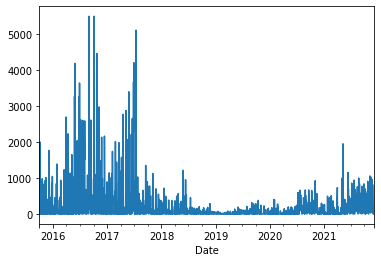

In [22]:
ita_df_D.plot()

<AxesSubplot:xlabel='Date'>

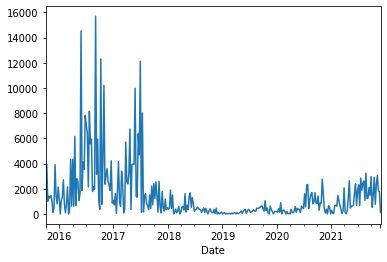

In [23]:
ita_df_W.plot()

<AxesSubplot:xlabel='Date'>

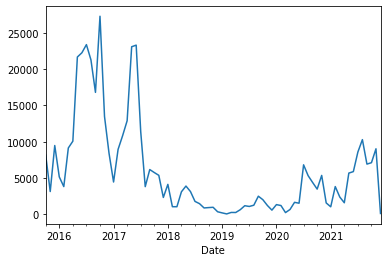

In [24]:
ita_df_M.plot()

## Decompose of the Time Series

In [38]:
decompose_ita_M= sm.tsa.seasonal_decompose(ita_df_M, model="additive")
decompose_ita_W= sm.tsa.seasonal_decompose(ita_df_W, model="additive")
decompose_ita_D= sm.tsa.seasonal_decompose(ita_df_D, model="additive")

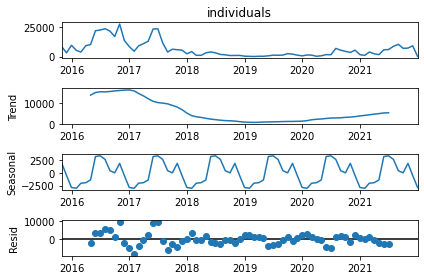

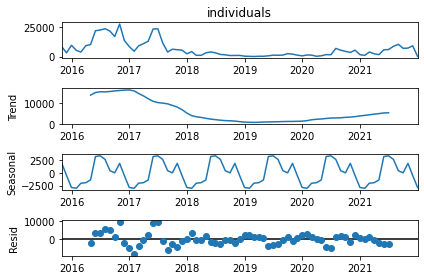

In [39]:
decompose_ita_M.plot()

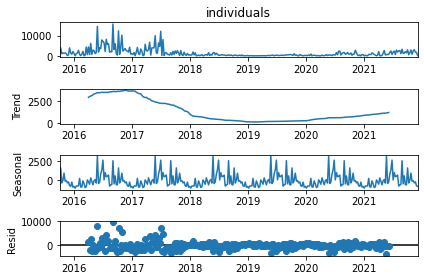

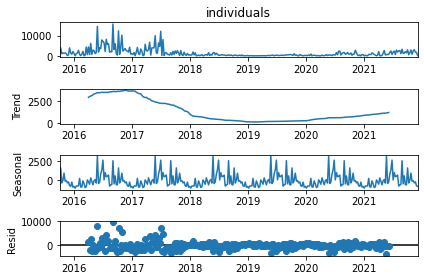

In [28]:
decompose_ita_W.plot()

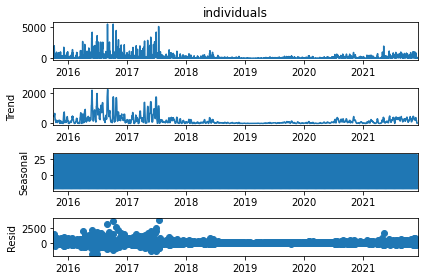

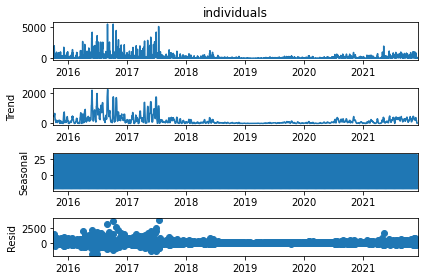

In [29]:
decompose_ita_D.plot()

### Data Transformation to make the Time Series Stationary with classical shifting Method --> Arima and SARIMA are doing this with the Hyperparameter


In [30]:
# output[i] = ita_df_diff_M[i+1]
ita_df_diff_M = ita_df_M.diff(periods=1)
ita_df_diff_W = ita_df_W.diff(periods=1)
ita_df_diff_D = ita_df_D.diff(periods=1)

In [31]:

ita_df_diff_M = ita_df_diff_M[1:]
ita_df_diff_W = ita_df_diff_W[1:]
ita_df_diff_D = ita_df_diff_D[1:]

<function matplotlib.pyplot.show(close=None, block=None)>

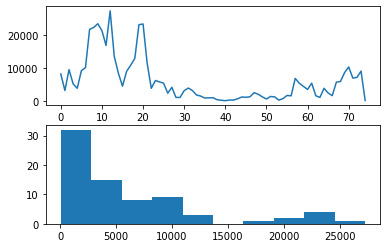

In [32]:
# Box- Cox Transform Test
# The Data must be positiv at any Datapoint --> weekly and daily has some 0 values
from scipy.stats import boxcox
from pandas import DataFrame
x = DataFrame(ita_df_M.values)
x.columns = ["individuals"]
x["individuals"] = boxcox(x["individuals"], lmbda=1.0)



plt.figure(1)
plt.subplot(211)
plt.plot(x["individuals"])

plt.subplot(212)
plt.hist(x["individuals"])

plt.show



<AxesSubplot:>

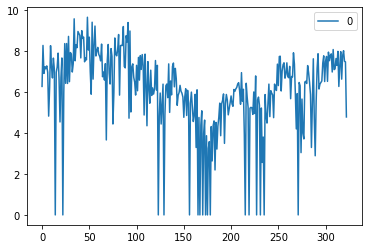

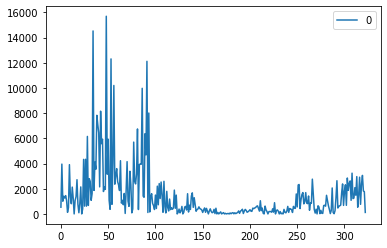

In [33]:
y = DataFrame(ita_df_W.values)
y_transformed = np.log(y+1)
y_transformed.plot()
y.plot()

<AxesSubplot:xlabel='Date'>

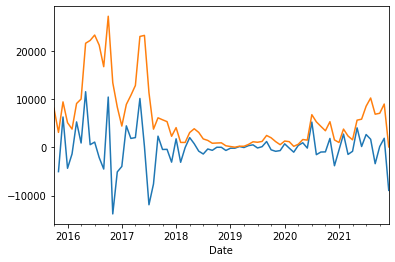

In [34]:
ita_df_diff_M.plot()
ita_df_M.plot()





<AxesSubplot:xlabel='Date'>

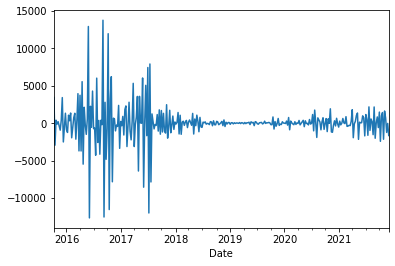

In [35]:
ita_df_diff_W.plot()
#ita_df_W.plot()

<AxesSubplot:xlabel='Date'>

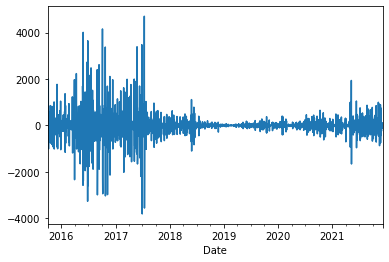

In [36]:
ita_df_diff_D.plot()


<AxesSubplot:xlabel='Date'>

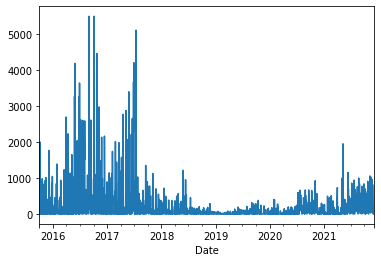

In [37]:
ita_df_D.plot()

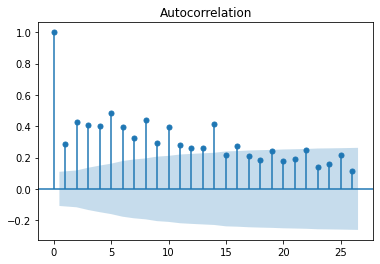

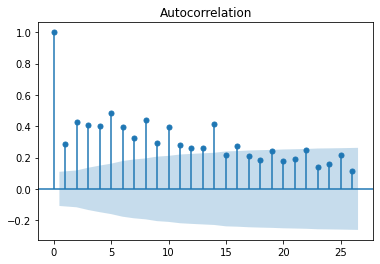

In [38]:
plot_acf(ita_df_W)


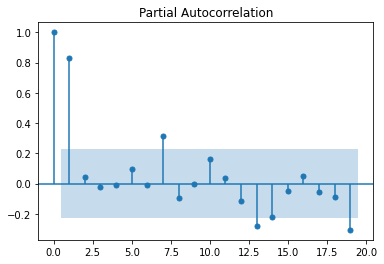

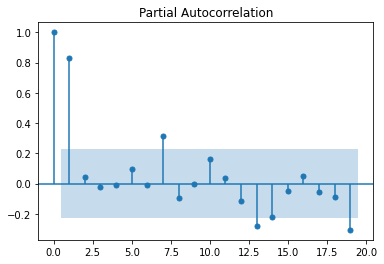

In [39]:
plot_pacf(ita_df_M)

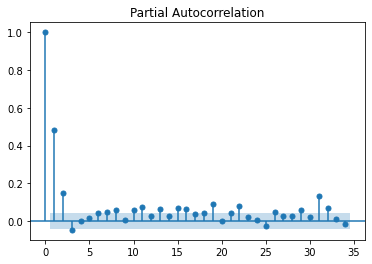

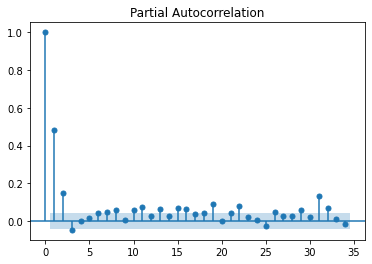

In [40]:
plot_pacf(ita_df_D)

# Train Test Split des Datensatzes

In [41]:
ita_df_W.shape


(323,)

In [42]:
# Same Data as in Marco Notebook differenciated and not differenciated --> weekly
ita_df_w_same= ita_df_W["2017-06-25":"2020-06-29"]
ita_df_w_same_diff= ita_df_diff_W["2017-06-25":"2020-06-29"]

In [43]:
ita_df_d_same = ita_df_D["2017-06-25":"2020-06-29"]
ita_df_d_same_diff = ita_df_diff_D["2017-06-25":"2020-06-29"]


In [44]:
ita_df_M_same  = ita_df_M["2017-06-25":"2020-06-29"]

Splitt Data into Train, Test

In [45]:
# Kompletter Datensatz
train_set_w, test_set_w= np.split(ita_df_W, [int(.80 *len(ita_df_W))])

# Differenciated Dataset
train_set_w_diff, test_set_w_diff= np.split(ita_df_diff_W, [int(.80 *len(ita_df_diff_W))])
train_set_w_diff = train_set_w_diff.dropna()
test_set_w_diff = test_set_w_diff.dropna()




In [46]:
# Datenanfang gleich wie bei iom_weekly_model Marco
train_set_same_w, test_set_same_w= np.split(ita_df_w_same, [int(.80 *len(ita_df_w_same))])
train_set_same_w.shape

(126,)

In [47]:
# Daily Daten Gesamter Datensatz
train_set_d, test_set_d= np.split(ita_df_D, [int(.80 *len(ita_df_D))])

# Differenciated
train_set_d_diff, test_set_d_diff= np.split(ita_df_d_same_diff, [int(.80 *len(ita_df_d_same_diff))])


In [48]:
train_set_monthly, test_set_monthly= np.split(ita_df_M, [int(.80 *len(ita_df_M))])

train_set_monthly_diff, test_set_monthly_diff= np.split(ita_df_diff_M, [int(.80 *len(ita_df_diff_M))])

In [49]:
test_set_same_w.head()

Date
2019-11-24    622
2019-12-01    317
2019-12-08    191
2019-12-15      0
2019-12-22    183
Freq: W-SUN, Name: individuals, dtype: int64

(<AxesSubplot:title={'center':'Arrivals of individuals in Italy'}, xlabel='Date'>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:title={'center':'Partial Autocorrelation'}>)

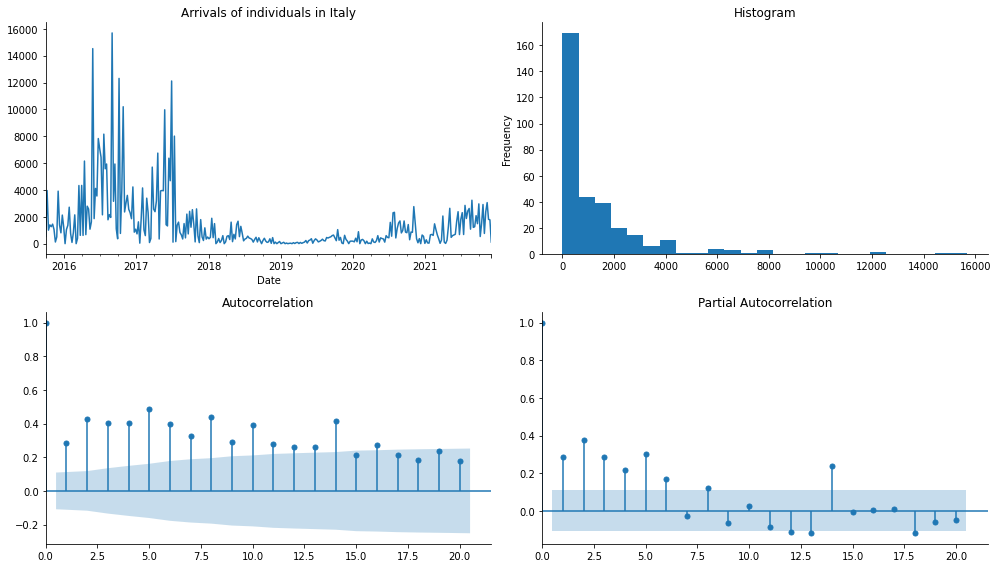

In [50]:
# Function for Plotting helpful Graphs
tsplot(ita_df_W, title="Arrivals of individuals in Italy",lags=20)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

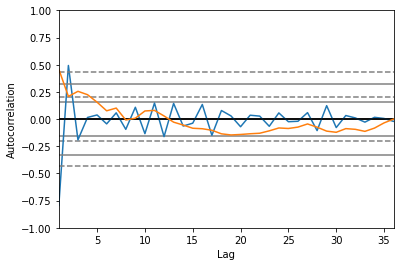

In [51]:
# Random Walk??? für ita_df_d_same_diff?
autocorrelation_plot(ita_df_w_same_diff)
autocorrelation_plot(ita_df_M_same)


In [52]:
#combined_df["individuals"].plot()
ita_df_W

Date
2015-10-04     533
2015-10-11    3954
2015-10-18    1007
2015-10-25    1399
2015-11-01    1265
              ... 
2021-11-07    2380
2021-11-14    3058
2021-11-21    1814
2021-11-28    1774
2021-12-05     119
Freq: W-SUN, Name: individuals, Length: 323, dtype: int64

# Statistical Tests to evaluate stationarity of the Time Series

In [53]:
# Test for stationarity if ADF is more negative than our critical values the series is stationary
from statsmodels.tsa.stattools import adfuller

X = ita_df_W.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.165505
p-value: 0.219002
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


In [44]:
# Other Method to check if the series is stationary or not


from statsmodels.tsa.stattools import kpss
t_stat, p_value, _, critical_values = kpss(ita_df_M.values, nlags='auto')

print(f'ADF Statistic: {t_stat:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'   {key}, {value:.2f}')

print(f'\np-value: {p_value:.2f}')
print("Stationary") if p_value > 0.05 else print("Non-Stationary")

ADF Statistic: 0.58
Critial Values:
   10%, 0.35
Critial Values:
   5%, 0.46
Critial Values:
   2.5%, 0.57
Critial Values:
   1%, 0.74

p-value: 0.02
Non-Stationary


# Persistence Modell als Baseline : Autocorrelationplot weißt auf Randomwalk hin



In [55]:
def persistence_modell_evaluate(data):
    # Supervised Learning Problem
    values = DataFrame(data)
    dataframe = concat([values.shift(1), values], axis = 1)
    dataframe.columns = ["t", "t+1"]
    dataframe.head()


    # Train Test split according to Jason Brownlee
    X = dataframe.values
    train_size = int(len(X)*0.8)
    train_persistence, test_persistence = X[1:train_size], X[train_size:]
    train_X_persistence, train_y_persistence = train_persistence[:,0] , train_persistence[:,1]
    test_X_persistence, test_y_persistence = test_persistence[:,0] , test_persistence[:,1]
    # persistence Model
    def model_persistence(x):
        return x

    # Walk forward validation
    p = list()
    for x in test_X_persistence:
        yhat = model_persistence(x)
        p.append(yhat)
    rmse = sqrt(mean_squared_error(test_y_persistence, p))
    print(rmse)
    series_predicted = pd.Series(p, dtype='float64')
    test_series = pd.Series(test_y_persistence, dtype='float64')
  
     

    series_predicted.plot(color = "red")
    test_series.plot()
    

## Persistence Mpodell Evaluation

286.9573370282354


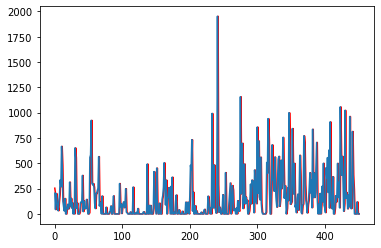

In [56]:
# Daily Data
persistence_modell_evaluate(ita_df_D)

318.1646095184064


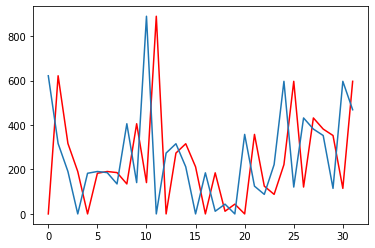

In [57]:
# Weekly Data Same as Marco --> Reference Data
persistence_modell_evaluate(ita_df_w_same)

1088.8262911537781


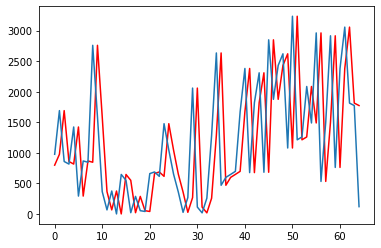

In [58]:
# weekly dataset
persistence_modell_evaluate(ita_df_W)

571.3435918954548


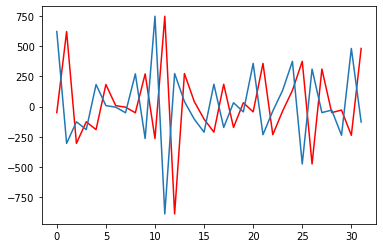

In [59]:
# Differenced weekly dataset
persistence_modell_evaluate(ita_df_w_same_diff)

1861.8933043875197


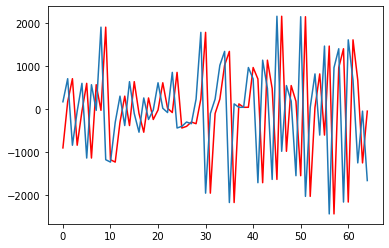

In [60]:
# Differenced weekly dataset complete
persistence_modell_evaluate(ita_df_diff_W)

3170.0245635220767


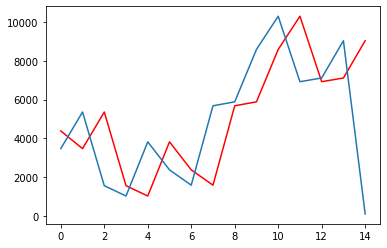

In [61]:
# Monthly Data Same
persistence_modell_evaluate(ita_df_M)

4353.9307987151105


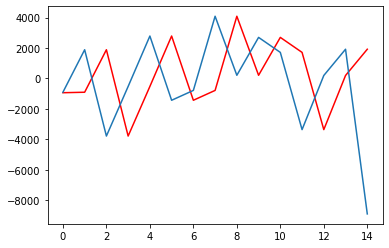

In [62]:
persistence_modell_evaluate(ita_df_diff_M)

In [63]:
from statsmodels.tsa.ar_model import AutoReg

# Helper Functions for Plotting and Evaluating Model Performance with Error Metrics

In [64]:
# Helper Funktion um Modelle zu Plotten und zu evaluieren --> Exogen falls Multivariater Input verwendet wird
def fit_plot_evaluate(model, trainset, testset, exogen = None, eliminate_0 = True):
    
    if  exogen is not None:
        fit = model.fit()
        predict = fit.predict(start=len(trainset), end=len(trainset)+len(testset)-1,exog = exogen, dynamic = False, type = 'levels')

        
        # In der Zeitreihenanalyse werden negative Werte mit 0 ersetzt, da es für den Forecast in unserem Use Case keinen Sinn macht

        if eliminate_0 is True:
            predict = predict.apply(lambda x : x if x > 0 else 0)
        else:
            testset.plot()
            predict.plot(color = 'red')
        mean_squared_Error = sqrt(mean_squared_error(testset["individuals"], predict))
        precentage_error = mean_absolute_percentage_error(testset["individuals"], predict)
        testset["individuals"].plot()
        predict.plot(color = 'red')
        
        
    else:
        fit = model.fit()
        predict = fit.predict(start=len(trainset), end=len(trainset)+len(testset)-1, dynamic = False)
        
        # In der Zeitreihenanalyse werden negative Werte mit 0 ersetzt, da es für den Forecast in unserem Use Case keinen Sinn macht

        if eliminate_0 is True:
            predict = predict.apply(lambda x : x if x > 0 else 0)
            testset.plot()
            predict.plot(color = 'red')
        
        
        else:
            testset.plot()
            predict.plot(color = 'red')
        mean_squared_Error = sqrt(mean_squared_error(testset, predict))
        precentage_error = mean_absolute_percentage_error(testset, predict) 
        
        

    
    return mean_squared_Error, precentage_error

In [65]:
from contextlib import suppress


# Um den besten Lag Parameter zu finden nutzen wir diese Funktion
def find_best_lag(traindata, testdata,eliminate_0 = True):
    results =[]
    try:
        for i in range(0,25):
            AR_Modell_same_t = AutoReg(traindata, lags = i, seasonal = True, old_names=False)
            AR_fit_t = AR_Modell_same_t.fit()
            prediction = AR_fit_t.predict(start=len(traindata), end=len(traindata)+len(testdata)-1, dynamic = False)
            if eliminate_0 is True:
                prediction = prediction.apply(lambda x : x if x > 0 else 0)
                error = sqrt(mean_squared_error(testdata, prediction))
                results.append(error)
            else:
                
                error = sqrt(mean_squared_error(testdata, prediction))
                results.append(error)
            #print("RMSE: ", error, i)
            # Falls RMSE in der Liste am Kleinsten  speichern wir i in einer Variable und geben sie aus
            if error == min(results):
                best_lag = i
        print("Bester Lag: ", best_lag, " RMSE: ", min(results))
# division by 0 Error handling
    except:
        print("Bester Lag: ", best_lag , " RMSE: ", min(results))

    

## Using helper Function to determine the best Lag for AR Modell

In [66]:
# Beste Lags für daily Daten
find_best_lag(train_set_d,test_set_d)

Bester Lag:  23  RMSE:  241.1567668350109


In [67]:
test_set_w.shape

(65,)

In [68]:
find_best_lag(train_set_d_diff,test_set_d_diff)

Bester Lag:  22  RMSE:  92.01297328532172


In [69]:
# Best lag weekly data
find_best_lag(train_set_w, test_set_w)

Bester Lag:  14  RMSE:  1140.091886159783


In [70]:
find_best_lag(train_set_w_diff, test_set_w_diff, eliminate_0=False)

Bester Lag:  4  RMSE:  1535.268904072432


In [71]:
# Beste Lags für Weekly Marco Daten
find_best_lag(train_set_same_w, test_set_same_w)

Bester Lag:  12  RMSE:  231.67971965508465


In [72]:
# Best monthly lag
find_best_lag(train_set_monthly, test_set_monthly)

Bester Lag:  4  RMSE:  2582.3537586383227


C:\Users\hornd\AppData\Local\R-MINI~1\lib\site-packages\statsmodels\regression\linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [73]:
find_best_lag(train_set_monthly_diff, test_set_monthly_diff)

Bester Lag:  11  RMSE:  3066.0809836540398


## Als Baselinemodell nutzen wir das Autoregressive Modell, da es von allen das einfachste ist:

In [74]:
# Lags how many past observations should be considered in the Modell
AR_Modell_w = AutoReg(train_set_w, lags = 23, seasonal = True)

C:\Users\hornd\AppData\Local\R-MINI~1\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [75]:
AR_Modell_d = AutoReg(train_set_d, lags = 23, seasonal = True)
AR_Modell_d_diff = AutoReg(train_set_d_diff, lags = 22, seasonal = True)

In [76]:
AR_Modell_m = AutoReg(train_set_monthly, lags = 18, seasonal = True)

In [77]:
AR_Modell_diff_w = AutoReg(train_set_w_diff, lags = 24 , seasonal = True)
AR_Modell_same_weekly = AutoReg(train_set_same_w, lags = 12, seasonal = True)

(1161.804073139065, 5.543523887067794e+16)

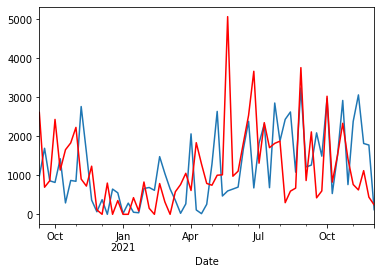

In [78]:
fit_plot_evaluate(AR_Modell_w, train_set_w, test_set_w, eliminate_0= True)

In [186]:
test_set_w

Date
2020-09-13     976
2020-09-20    1691
2020-09-27     858
2020-10-04     816
2020-10-11    1423
              ... 
2021-11-07    2380
2021-11-14    3058
2021-11-21    1814
2021-11-28    1774
2021-12-05     119
Freq: W-SUN, Name: individuals, Length: 65, dtype: int64

(1567.6142450848192, 6.311521243632294)

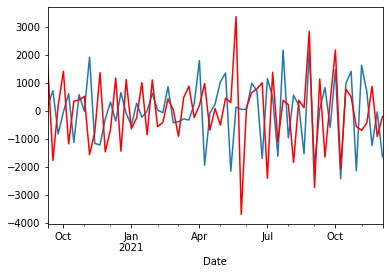

In [80]:
# differenced ar modell --> Worse Performance than normal weekly data
fit_plot_evaluate(AR_Modell_diff_w, train_set_w_diff, test_set_w_diff, eliminate_0= False)

(1161.804073139065, 5.543523887067794e+16)

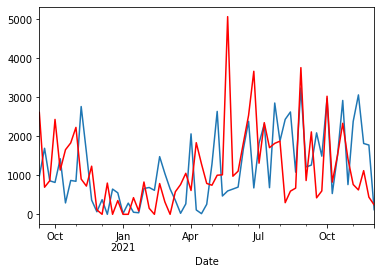

In [81]:
fit_plot_evaluate(AR_Modell_w, train_set_w, test_set_w, eliminate_0= True)

(96.74739037236738, 3.8816218608484344e+16)

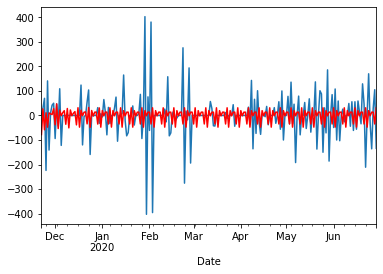

In [82]:
fit_plot_evaluate(AR_Modell_d_diff, train_set_d_diff, test_set_d_diff, eliminate_0=False)

(241.1567668350109, 2.584618055803388e+17)

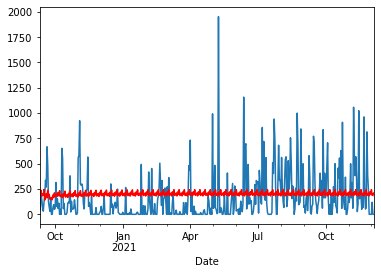

In [83]:
fit_plot_evaluate(AR_Modell_d,train_set_d,test_set_d)

(3107.4429560907297, 2.5974838842446766)

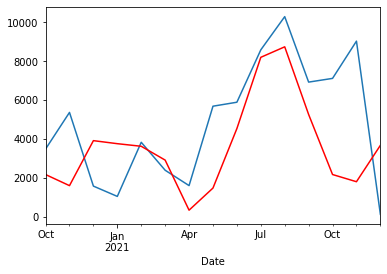

In [84]:
#Angepasster Datensatz
fit_plot_evaluate(AR_Modell_m,train_set_monthly,test_set_monthly)

(231.67971965508465, 7.02040396704414e+16)

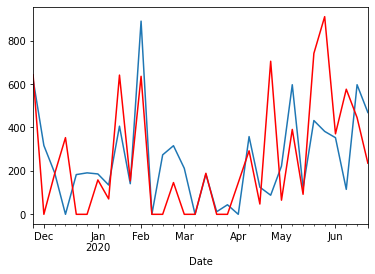

In [85]:
fit_plot_evaluate(AR_Modell_same_weekly,train_set_same_w, test_set_same_w , eliminate_0=True)


In [86]:
ita_df_w_same

Date
2017-06-25     4688
2017-07-02    12115
2017-07-09      112
2017-07-16     8010
2017-07-23      152
              ...  
2020-05-31      382
2020-06-07      353
2020-06-14      115
2020-06-21      597
2020-06-28      469
Freq: W-SUN, Name: individuals, Length: 158, dtype: int64

In [87]:
from pmdarima.arima import auto_arima

model =  auto_arima(train_set_w_diff, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, stepwise=True)
model_fit = model.fit(train_set_w_diff)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4620.540, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4819.816, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4706.025, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4636.442, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4817.816, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4618.544, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=4619.586, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4624.852, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=4620.930, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=4619.819, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4625.086, Time=0.03 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=4621.591, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4616.538, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4617.587, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]          

In [88]:
#fit_plot_evaluate(model,train_set_w_diff ,test_set_w_diff)

Wir sehen, dass die Vorhersage mit den Daten ab 2017 genauer ist im Vergleich zur Vorhersage mit dem gesamten Datensatz


# ARIMA test 
## Hypothese : Da es sich um Seasonal Daten handelt sollte dieses Modell schlechtere Ergebnisse liefern als beispielsweise SArima, da es die Seasonale Komponente der Zeitreihe nicht erfassen kann

In [89]:
#arima_model_ita_same_w = ARIMA(train_set_same_w, order=(2,2,0))
#
arima_model_ita_same_w = ARIMA(train_set_same_w, order=(22,1,0))


#arima_model_ita_w = ARIMA(train_set_w, order=(2,2,0))


C:\Users\hornd\AppData\Local\R-MINI~1\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [90]:
#fit_plot_evaluate(arima_model_ita_same_w,train_set_same_w,test_set_same_w)

# SARIMA test




In [91]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Trend
- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

# Seasonal

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period.


C:\Users\hornd\AppData\Local\R-MINI~1\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(934.1794469563495, 5.881274807572815e+16)

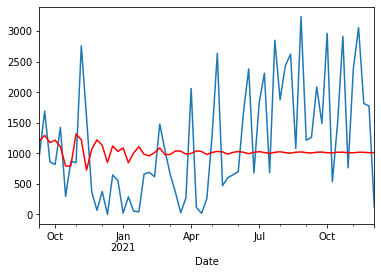

In [92]:
#Sarima_Modell = SARIMAX(train_set,order = (2,1,0), seasonal_order=(1,2,1,12))
#Sarima_Modell_same = SARIMAX(train_set_same_w,order = (2,1,0), seasonal_order=(0,1,0,12))
#Sarima_Modell_same = SARIMAX(train_set_same_w,order = (12,1,2), seasonal_order=(0,1,0,12))
Sarima_Modell_same = SARIMAX(train_set_w,order = (5,1,10), seasonal_order=(0,0,2,12))
fit_plot_evaluate(Sarima_Modell_same, train_set_w, test_set_w)
# Ähnlich Ergebnisse wie beim AR Modell

In [93]:
#train_set_same_w.isnull().sum()

# Helper Function for a rolling Forecast where the Model is retrained before each prediction with the actual value (also called walk forward validation)

# SARIMA

In [94]:
# Function for Rolling Forecast with Sarima
def rolling_forecast(traindata,test_data, Modell_order = None , Sarima_order = None, eliminate_0 = True, lala= None):
    history = [x for x in traindata]
    predictions = list()
  
    for t in range(len(test_data)):
        Sarima_Modell_same = SARIMAX(history,order = Modell_order ,seasonal_order= Sarima_order, exog=lala)
        model_fit = Sarima_Modell_same.fit()
        output = model_fit.forecast(steps = 1,exog=lala)
        
        yhat = output[0]
        obs = test_data[t]
        predictions.append(yhat)
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    
    series_predicted = pd.Series(predictions, dtype='float64')
    series_predicted.index = test_data.index

    if eliminate_0 is True:
        # Eliminate 0 values --> (for differenced Time Series not applyable because of negativ values)
        series_predicted = series_predicted.apply(lambda x : x if x > 0 else 0)
        test_data.plot()
        series_predicted.plot(color = 'red')
    else:
        test_data.plot()
        series_predicted.plot(color = 'red')

    print(sqrt(mean_squared_error(test_data, series_predicted)))
    


# ARIMA

In [95]:
# Function for Rolling Forecast with Arima
def rolling_forecast_arima(traindata,test_data, Modell_order = None):
    history = [x for x in traindata]
    predictions = list()
  
    for t in range(len(test_data)):
        Sarima_Modell_same = ARIMA(history,order = Modell_order)
        model_fit = Sarima_Modell_same.fit()
        output = model_fit.forecast(steps = 1)
        
        yhat = output[0]
        obs = test_data[t]
        predictions.append(yhat)
        history.append(obs)
        
    
    
    series_predicted = pd.Series(predictions)
    series_predicted = series_predicted.apply(lambda x : x if x > 0 else 0)
    series_predicted = series_predicted.astype(np.int64)
    series_predicted.index = test_data.index

    

    test_data.plot()
    series_predicted.plot(color = "red")
    print(type(test_data[0]))
    print(type(series_predicted[0]))
    print(sqrt(mean_squared_error(test_data, series_predicted)))
    print(mean_absolute_percentage_error(test_data, series_predicted))

C:\Users\hornd\AppData\Local\R-MINI~1\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'numpy.int64'>
<class 'numpy.int64'>
824.883534902865
9.845561646913038e+16


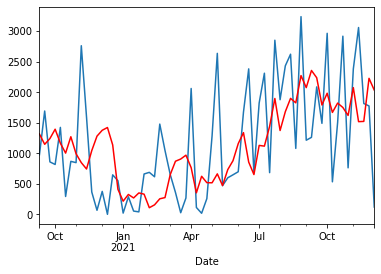

In [96]:
#rolling_forecast_arima(train_set_same_w, test_set_same_w, (4,2,1))
rolling_forecast_arima(train_set_w, test_set_w, (5,1,0))

In [97]:
#rolling_forecast_arima(train_set_w_diff, test_set_w_diff, (15,0,0))

In [98]:
#rolling_forecast(train_set_d_diff,test_set_d_diff,(1,0,1), eliminate_0 = False)
#train_set_d_diff

In [99]:
# Weekly Dataset --> Same as Marco
#rolling_forecast(train_set_same_w, test_set_same_w, (2,1,0) , (0,0,0,12))

In [100]:
# Weekly Dataset full Data
#rolling_forecast(train_set_w, test_set_w, (30,1,0) , (0,0,0,12), eliminate_0=True)

2761.8755539634712


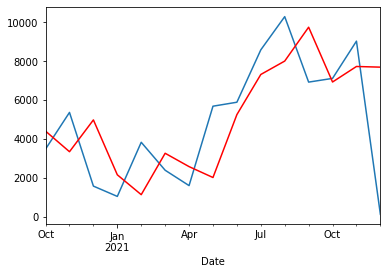

In [101]:
# Monthly Data full
rolling_forecast(train_set_monthly, test_set_monthly, (2,1,0) , (1,0,0,12), eliminate_0=True)


In [102]:
# Daily Data

#rolling_forecast(train_set_d, test_set_d, (2,1,0) , (1,1,0,12), eliminate_0=True)


In [103]:
Sarima_fit_same = Sarima_Modell_same.fit()
Sarima_fit_same.summary()

C:\Users\hornd\AppData\Local\R-MINI~1\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                         
================================================================================================
Dep. Variable:                              individuals   No. Observations:                  258
Model:             SARIMAX(5, 1, 10)x(0, 0, [1, 2], 12)   Log Likelihood               -2287.843
Date:                                  Thu, 30 Dec 2021   AIC                           4611.686
Time:                                          14:59:08   BIC                           4675.570
Sample:                                      10-04-2015   HQIC                          4637.377
                                           - 09-06-2020                                         
Covariance Type:                                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7264      0.952     -1.813      0.070      -3.593       0.140
ar.L2         -1.8945      1.557     -1.217      0.224      -4.947       1.158
ar.L3         -1.7059      1.597     -1.068      0.285      -4.836       1.424
ar.L4         -0.8007      1.425     -0.562      0.574      -3.594       1.992
ar.L5         -0.1475      0.566     -0.260      0.795      -1.257       0.962
ma.L1          0.6768      0.937      0.722      0.470      -1.160       2.513
ma.L2          0.3133      0.576      0.544      0.586      -0.815       1.441
ma.L3          0.0817      0.198      0.413      0.680      -0.307       0.470
ma.L4         -0.5971      0.126     -4.723      0.000      -0.845      -0.349
ma.L5         -0.1152      0.591     -0.195      0.845      -1.273       1.043
ma.L6          0.2106      0.142      1.487      0.137      -0.067       0.488
ma.L7          0.1050      0.301      0.349      0.727      -0.485       0.695
ma.L8          0.0909      0.077      1.178      0.239      -0.060       0.242
ma.L9         -0.1734      0.085     -2.040      0.041      -0.340      -0.007
ma.L10         0.0453      0.209      0.217      0.828      -0.364       0.455
ma.S.L12      -0.1879      0.075     -2.498      0.013      -0.335      -0.040
ma.S.L24      -0.0518      0.057     -0.913      0.361      -0.163       0.059
sigma2      2.978e+06   1.86e+05     16.002      0.000    2.61e+06    3.34e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1119.54
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                             1.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.63e+14. Standard errors may be unstable.
"""

In [104]:
#prediction = Sarima_fit.predict(start=len(train_set), end=len(train_set)+len(test_set)-1)
prediction_same = Sarima_fit_same.predict(start=len(train_set_same_w), end=len(train_set_same_w)+len(test_set_same_w)-1)



<AxesSubplot:xlabel='Date'>

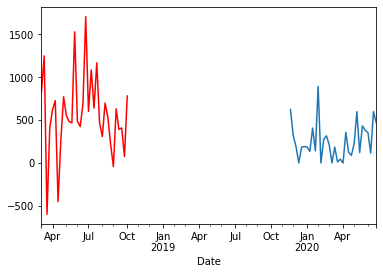

In [105]:
# Same data as git repo
test_set_same_w.plot()
prediction_same.plot(color = 'red')



In [106]:
from sklearn.metrics import mean_absolute_percentage_error

# Adding Weather Data as preparation for the Multivariate Analysis


In [107]:
#weather_ita = pd.read_csv("Tripoli_Weahter_Data.csv", sep = ",", dayfirst=True)
weather_ita = pd.read_csv("POWER_Point_Daily_20151001_20211205_032d8994N_013d2026E_LST.csv", sep = ",", dayfirst=True)
weather_ita["Date"] = pd.to_datetime((weather_ita.YEAR*10000+weather_ita.MO*100+weather_ita.DY).apply(str),format='%Y%m%d')
weather_ita = weather_ita.set_index("Date")

In [108]:
#weather_ita = weather_ita.shift(7)

In [109]:
#weather_ita = weather_ita.drop(["LAT","LON","YEAR","MO","DY"], axis = 1)
weather_ita = weather_ita.drop(["YEAR","MO","DY"], axis = 1)
weather_ita


,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,PS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WD10M,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,WD50M
Date,,,,,,,,,,,,,,,,,,
2015-10-01,25.33,19.51,22.42,26.04,5.24,28.17,22.93,101.45,4.28,7.16,0.60,6.55,151.31,5.02,8.65,0.70,7.95,152.19
2015-10-02,24.50,20.08,22.30,25.51,1.58,25.25,23.67,101.59,2.29,4.20,1.36,2.84,160.25,2.70,5.26,1.35,3.91,144.75
2015-10-03,24.78,21.23,23.00,25.83,3.32,26.73,23.41,101.84,4.38,6.30,3.34,2.95,75.69,5.03,7.39,3.97,3.42,76.81
2015-10-04,25.15,22.01,23.58,25.95,2.48,26.65,24.17,102.01,2.71,3.68,1.30,2.38,183.56,3.05,4.23,1.42,2.80,183.25
2015-10-05,25.48,19.43,22.45,26.02,3.30,27.17,23.87,101.83,2.05,3.09,0.68,2.41,253.69,2.25,3.32,0.79,2.53,254.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,16.79,8.17,12.48,19.12,2.64,18.18,15.53,102.20,3.56,5.00,1.48,3.52,265.75,3.92,5.23,1.70,3.53,266.31
2021-12-02,17.75,8.08,12.91,19.23,6.92,21.40,14.48,101.24,5.80,7.49,3.39,4.10,231.25,6.80,8.49,4.02,4.47,230.81
2021-12-03,16.01,9.08,12.54,18.82,3.57,18.07,14.50,100.93,9.07,10.98,6.66,4.31,266.00,10.62,12.62,8.04,4.58,266.88


In [110]:
weather_ita_daily = weather_ita
weather_ita_daily

,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,PS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WD10M,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,WD50M
Date,,,,,,,,,,,,,,,,,,
2015-10-01,25.33,19.51,22.42,26.04,5.24,28.17,22.93,101.45,4.28,7.16,0.60,6.55,151.31,5.02,8.65,0.70,7.95,152.19
2015-10-02,24.50,20.08,22.30,25.51,1.58,25.25,23.67,101.59,2.29,4.20,1.36,2.84,160.25,2.70,5.26,1.35,3.91,144.75
2015-10-03,24.78,21.23,23.00,25.83,3.32,26.73,23.41,101.84,4.38,6.30,3.34,2.95,75.69,5.03,7.39,3.97,3.42,76.81
2015-10-04,25.15,22.01,23.58,25.95,2.48,26.65,24.17,102.01,2.71,3.68,1.30,2.38,183.56,3.05,4.23,1.42,2.80,183.25
2015-10-05,25.48,19.43,22.45,26.02,3.30,27.17,23.87,101.83,2.05,3.09,0.68,2.41,253.69,2.25,3.32,0.79,2.53,254.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,16.79,8.17,12.48,19.12,2.64,18.18,15.53,102.20,3.56,5.00,1.48,3.52,265.75,3.92,5.23,1.70,3.53,266.31
2021-12-02,17.75,8.08,12.91,19.23,6.92,21.40,14.48,101.24,5.80,7.49,3.39,4.10,231.25,6.80,8.49,4.02,4.47,230.81
2021-12-03,16.01,9.08,12.54,18.82,3.57,18.07,14.50,100.93,9.07,10.98,6.66,4.31,266.00,10.62,12.62,8.04,4.58,266.88


In [111]:
# As we are dealing with Daily Data we are taking the Mean for the week in order to mtach the weekly Arrival Data
weather_ita_weekly=weather_ita.resample("W").mean()
weather_ita_weekly


,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,PS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WD10M,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,WD50M
Date,,,,,,,,,,,,,,,,,,
2015-10-04,24.940000,20.707500,22.825000,25.832500,3.155000,26.700000,23.545000,101.722500,3.415000,5.335000,1.650000,3.680000,142.702500,3.950000,6.382500,1.860000,4.520000,139.250000
2015-10-11,25.885714,19.757143,22.821429,26.025714,4.335714,28.368571,24.031429,101.134286,4.458571,6.805714,2.138571,4.670000,203.731429,5.361429,8.341429,2.417143,5.925714,204.197143
2015-10-18,25.215714,19.607143,22.410000,25.705714,4.342857,27.615714,23.272857,101.238571,3.888571,5.818571,1.500000,4.322857,150.401429,4.647143,7.072857,1.707143,5.365714,152.722857
2015-10-25,23.492857,17.664286,20.580000,24.511429,3.121429,25.144286,22.021429,101.232857,6.435714,8.564286,4.691429,3.875714,244.132857,7.614286,10.364286,5.501429,4.862857,244.304286
2015-11-01,22.417143,15.727143,19.071429,23.565714,2.847143,23.917143,21.067143,101.551429,3.797143,5.378571,2.170000,3.211429,189.962857,4.358571,6.221429,2.510000,3.714286,191.895714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-07,24.351429,14.838571,19.595714,23.990000,5.398571,27.467143,22.065714,101.030000,4.632857,6.664286,1.724286,4.935714,211.161429,5.774286,8.370000,1.935714,6.435714,210.812857
2021-11-14,20.590000,13.997143,17.295714,22.294286,2.564286,21.898571,19.337143,101.367143,4.292857,6.107143,2.241429,3.867143,228.304286,4.885714,7.037143,2.544286,4.488571,228.471429
2021-11-21,20.368571,12.380000,16.372857,21.655714,3.638571,22.264286,18.624286,101.598571,4.104286,5.472857,1.844286,3.632857,148.885714,4.744286,6.478571,2.110000,4.371429,149.122857


In [112]:
#weather_ita_weekly_adjusted = weather_ita_weekly["2017-06-25":"2021-07-11"]
weather_ita_weekly_adjusted = weather_ita_weekly["2015-10-01":"2021-12-05"] 
weather_ita_weekly_adjusted

,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,PS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WD10M,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,WD50M
Date,,,,,,,,,,,,,,,,,,
2015-10-04,24.940000,20.707500,22.825000,25.832500,3.155000,26.700000,23.545000,101.722500,3.415000,5.335000,1.650000,3.680000,142.702500,3.950000,6.382500,1.860000,4.520000,139.250000
2015-10-11,25.885714,19.757143,22.821429,26.025714,4.335714,28.368571,24.031429,101.134286,4.458571,6.805714,2.138571,4.670000,203.731429,5.361429,8.341429,2.417143,5.925714,204.197143
2015-10-18,25.215714,19.607143,22.410000,25.705714,4.342857,27.615714,23.272857,101.238571,3.888571,5.818571,1.500000,4.322857,150.401429,4.647143,7.072857,1.707143,5.365714,152.722857
2015-10-25,23.492857,17.664286,20.580000,24.511429,3.121429,25.144286,22.021429,101.232857,6.435714,8.564286,4.691429,3.875714,244.132857,7.614286,10.364286,5.501429,4.862857,244.304286
2015-11-01,22.417143,15.727143,19.071429,23.565714,2.847143,23.917143,21.067143,101.551429,3.797143,5.378571,2.170000,3.211429,189.962857,4.358571,6.221429,2.510000,3.714286,191.895714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-07,24.351429,14.838571,19.595714,23.990000,5.398571,27.467143,22.065714,101.030000,4.632857,6.664286,1.724286,4.935714,211.161429,5.774286,8.370000,1.935714,6.435714,210.812857
2021-11-14,20.590000,13.997143,17.295714,22.294286,2.564286,21.898571,19.337143,101.367143,4.292857,6.107143,2.241429,3.867143,228.304286,4.885714,7.037143,2.544286,4.488571,228.471429
2021-11-21,20.368571,12.380000,16.372857,21.655714,3.638571,22.264286,18.624286,101.598571,4.104286,5.472857,1.844286,3.632857,148.885714,4.744286,6.478571,2.110000,4.371429,149.122857


## We are Normalizing the Feautres to get better Prediction performance

In [113]:
from sklearn import preprocessing
import pandas as pd
scaler = preprocessing.MinMaxScaler()
names = weather_ita_weekly_adjusted.columns
weather_ita_weekly_adjusted[:]= scaler.fit_transform(weather_ita_weekly_adjusted)
weather_ita_weekly_adjusted  = pd.DataFrame(weather_ita_weekly_adjusted, columns=names)
weather_ita_weekly_adjusted

,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,PS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WD10M,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,WD50M
Date,,,,,,,,,,,,,,,,,,
2015-10-04,0.656862,0.877487,0.808929,0.721467,0.156774,0.546582,0.768094,0.470269,0.110282,0.211842,0.117011,0.368546,0.288239,0.113896,0.230589,0.113369,0.315418,0.270130
2015-10-11,0.707703,0.823467,0.808718,0.733065,0.288655,0.619368,0.795815,0.229057,0.259608,0.403235,0.185534,0.552025,0.546535,0.280114,0.441000,0.175294,0.508435,0.545413
2015-10-18,0.671684,0.814941,0.784342,0.713857,0.289453,0.586527,0.752585,0.271822,0.178046,0.274772,0.095973,0.487689,0.320824,0.195996,0.304741,0.096380,0.431542,0.327236
2015-10-25,0.579065,0.704507,0.675920,0.642171,0.153024,0.478719,0.681267,0.269479,0.542518,0.632088,0.543578,0.404819,0.717527,0.545424,0.658278,0.518101,0.362495,0.715410
2015-11-01,0.521235,0.594397,0.586543,0.585406,0.122387,0.425189,0.626883,0.400117,0.164963,0.217513,0.189942,0.281705,0.488261,0.162012,0.213288,0.185614,0.204786,0.493273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-07,0.625221,0.543890,0.617605,0.610873,0.407372,0.580046,0.683791,0.186292,0.284546,0.384830,0.127429,0.601271,0.577981,0.328735,0.444069,0.121785,0.578462,0.573454
2021-11-14,0.423009,0.496062,0.481337,0.509089,0.090793,0.337135,0.528291,0.324546,0.235895,0.312326,0.199960,0.403230,0.650535,0.224092,0.300905,0.189425,0.311102,0.648302
2021-11-21,0.411105,0.404141,0.426661,0.470760,0.210787,0.353088,0.487666,0.419449,0.208913,0.229782,0.144260,0.359809,0.314409,0.207436,0.240908,0.141156,0.295018,0.311977


In [114]:
combined_df_test = weather_ita_weekly_adjusted.merge(ita_df_W, left_index=True, right_index=True)
combined_df_test

,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,PS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WD10M,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,WD50M,individuals
Date,,,,,,,,,,,,,,,,,,,
2015-10-04,0.656862,0.877487,0.808929,0.721467,0.156774,0.546582,0.768094,0.470269,0.110282,0.211842,0.117011,0.368546,0.288239,0.113896,0.230589,0.113369,0.315418,0.270130,533
2015-10-11,0.707703,0.823467,0.808718,0.733065,0.288655,0.619368,0.795815,0.229057,0.259608,0.403235,0.185534,0.552025,0.546535,0.280114,0.441000,0.175294,0.508435,0.545413,3954
2015-10-18,0.671684,0.814941,0.784342,0.713857,0.289453,0.586527,0.752585,0.271822,0.178046,0.274772,0.095973,0.487689,0.320824,0.195996,0.304741,0.096380,0.431542,0.327236,1007
2015-10-25,0.579065,0.704507,0.675920,0.642171,0.153024,0.478719,0.681267,0.269479,0.542518,0.632088,0.543578,0.404819,0.717527,0.545424,0.658278,0.518101,0.362495,0.715410,1399
2015-11-01,0.521235,0.594397,0.586543,0.585406,0.122387,0.425189,0.626883,0.400117,0.164963,0.217513,0.189942,0.281705,0.488261,0.162012,0.213288,0.185614,0.204786,0.493273,1265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-07,0.625221,0.543890,0.617605,0.610873,0.407372,0.580046,0.683791,0.186292,0.284546,0.384830,0.127429,0.601271,0.577981,0.328735,0.444069,0.121785,0.578462,0.573454,2380
2021-11-14,0.423009,0.496062,0.481337,0.509089,0.090793,0.337135,0.528291,0.324546,0.235895,0.312326,0.199960,0.403230,0.650535,0.224092,0.300905,0.189425,0.311102,0.648302,3058
2021-11-21,0.411105,0.404141,0.426661,0.470760,0.210787,0.353088,0.487666,0.419449,0.208913,0.229782,0.144260,0.359809,0.314409,0.207436,0.240908,0.141156,0.295018,0.311977,1814


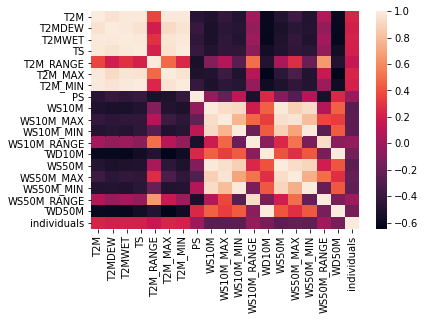

In [115]:
corr = combined_df_test.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

In [116]:
weather_ita_weekly_adjusted = weather_ita_weekly_adjusted.asfreq("W")

In [117]:
weather_ita_weekly_adjusted

,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,PS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WD10M,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,WD50M
Date,,,,,,,,,,,,,,,,,,
2015-10-04,0.656862,0.877487,0.808929,0.721467,0.156774,0.546582,0.768094,0.470269,0.110282,0.211842,0.117011,0.368546,0.288239,0.113896,0.230589,0.113369,0.315418,0.270130
2015-10-11,0.707703,0.823467,0.808718,0.733065,0.288655,0.619368,0.795815,0.229057,0.259608,0.403235,0.185534,0.552025,0.546535,0.280114,0.441000,0.175294,0.508435,0.545413
2015-10-18,0.671684,0.814941,0.784342,0.713857,0.289453,0.586527,0.752585,0.271822,0.178046,0.274772,0.095973,0.487689,0.320824,0.195996,0.304741,0.096380,0.431542,0.327236
2015-10-25,0.579065,0.704507,0.675920,0.642171,0.153024,0.478719,0.681267,0.269479,0.542518,0.632088,0.543578,0.404819,0.717527,0.545424,0.658278,0.518101,0.362495,0.715410
2015-11-01,0.521235,0.594397,0.586543,0.585406,0.122387,0.425189,0.626883,0.400117,0.164963,0.217513,0.189942,0.281705,0.488261,0.162012,0.213288,0.185614,0.204786,0.493273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-07,0.625221,0.543890,0.617605,0.610873,0.407372,0.580046,0.683791,0.186292,0.284546,0.384830,0.127429,0.601271,0.577981,0.328735,0.444069,0.121785,0.578462,0.573454
2021-11-14,0.423009,0.496062,0.481337,0.509089,0.090793,0.337135,0.528291,0.324546,0.235895,0.312326,0.199960,0.403230,0.650535,0.224092,0.300905,0.189425,0.311102,0.648302
2021-11-21,0.411105,0.404141,0.426661,0.470760,0.210787,0.353088,0.487666,0.419449,0.208913,0.229782,0.144260,0.359809,0.314409,0.207436,0.240908,0.141156,0.295018,0.311977


In [118]:
ita_df_W

Date
2015-10-04     533
2015-10-11    3954
2015-10-18    1007
2015-10-25    1399
2015-11-01    1265
              ... 
2021-11-07    2380
2021-11-14    3058
2021-11-21    1814
2021-11-28    1774
2021-12-05     119
Freq: W-SUN, Name: individuals, Length: 323, dtype: int64

In [119]:
weather_ita_weekly_adjusted.index = pd.to_datetime(weather_ita_weekly_adjusted.index)

# Combining both Dataframes final

In [120]:
# ita_df_W wird hier genutz, ergebnisse waren allerdings mit ita_df_w_same besser
combined_df = weather_ita_weekly_adjusted.merge(ita_df_W, left_index=True, right_index=True)
combined_df

,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,PS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WD10M,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,WD50M,individuals
Date,,,,,,,,,,,,,,,,,,,
2015-10-04,0.656862,0.877487,0.808929,0.721467,0.156774,0.546582,0.768094,0.470269,0.110282,0.211842,0.117011,0.368546,0.288239,0.113896,0.230589,0.113369,0.315418,0.270130,533
2015-10-11,0.707703,0.823467,0.808718,0.733065,0.288655,0.619368,0.795815,0.229057,0.259608,0.403235,0.185534,0.552025,0.546535,0.280114,0.441000,0.175294,0.508435,0.545413,3954
2015-10-18,0.671684,0.814941,0.784342,0.713857,0.289453,0.586527,0.752585,0.271822,0.178046,0.274772,0.095973,0.487689,0.320824,0.195996,0.304741,0.096380,0.431542,0.327236,1007
2015-10-25,0.579065,0.704507,0.675920,0.642171,0.153024,0.478719,0.681267,0.269479,0.542518,0.632088,0.543578,0.404819,0.717527,0.545424,0.658278,0.518101,0.362495,0.715410,1399
2015-11-01,0.521235,0.594397,0.586543,0.585406,0.122387,0.425189,0.626883,0.400117,0.164963,0.217513,0.189942,0.281705,0.488261,0.162012,0.213288,0.185614,0.204786,0.493273,1265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-07,0.625221,0.543890,0.617605,0.610873,0.407372,0.580046,0.683791,0.186292,0.284546,0.384830,0.127429,0.601271,0.577981,0.328735,0.444069,0.121785,0.578462,0.573454,2380
2021-11-14,0.423009,0.496062,0.481337,0.509089,0.090793,0.337135,0.528291,0.324546,0.235895,0.312326,0.199960,0.403230,0.650535,0.224092,0.300905,0.189425,0.311102,0.648302,3058
2021-11-21,0.411105,0.404141,0.426661,0.470760,0.210787,0.353088,0.487666,0.419449,0.208913,0.229782,0.144260,0.359809,0.314409,0.207436,0.240908,0.141156,0.295018,0.311977,1814


In [121]:
#combined_df["Shifted_TS_Weekly"] = combined_df["TS_RANGE_Weekly"].shift(3)
#combined_df["Shifted_TS_Weekly"] 

we normalized the feature values
subtracting the mean and dividing by the variance


In particular, from the weather features we used the forecasting mean and
max for wind speed, the forecasting gust speed and the forecasting mean for hu14 http://analysis.gdeltproject.org/module-gkg-exporter.html
A Multi-Scale Approach to Data-Driven Mass Migration Analysis 9
midity, temperature and sea level pressure

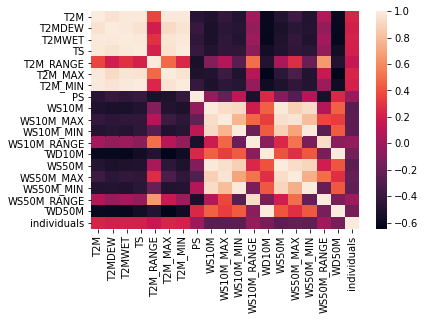

In [122]:
# Correlation Heatmap to identify correlation between the Series Data as we can see Temperature is positivley correlated and the windspeed is negativley correlated for the arrivals
corr = combined_df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

# Creating a DF with the Feautures and applying Train Test Split

In [123]:
# Setting up a two feautre DF for the SARIMAX Modell X standing for exogenous Variable --> Multivariate  
#two_feautre_df = combined_df_test[["T2M","WS10M_MAX","individuals"]]
#two_feautre_df = combined_df_test
two_feautre_df = combined_df
two_feautre_df.shape

(323, 19)

In [124]:
two_feautre_df

,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,PS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WD10M,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,WD50M,individuals
Date,,,,,,,,,,,,,,,,,,,
2015-10-04,0.656862,0.877487,0.808929,0.721467,0.156774,0.546582,0.768094,0.470269,0.110282,0.211842,0.117011,0.368546,0.288239,0.113896,0.230589,0.113369,0.315418,0.270130,533
2015-10-11,0.707703,0.823467,0.808718,0.733065,0.288655,0.619368,0.795815,0.229057,0.259608,0.403235,0.185534,0.552025,0.546535,0.280114,0.441000,0.175294,0.508435,0.545413,3954
2015-10-18,0.671684,0.814941,0.784342,0.713857,0.289453,0.586527,0.752585,0.271822,0.178046,0.274772,0.095973,0.487689,0.320824,0.195996,0.304741,0.096380,0.431542,0.327236,1007
2015-10-25,0.579065,0.704507,0.675920,0.642171,0.153024,0.478719,0.681267,0.269479,0.542518,0.632088,0.543578,0.404819,0.717527,0.545424,0.658278,0.518101,0.362495,0.715410,1399
2015-11-01,0.521235,0.594397,0.586543,0.585406,0.122387,0.425189,0.626883,0.400117,0.164963,0.217513,0.189942,0.281705,0.488261,0.162012,0.213288,0.185614,0.204786,0.493273,1265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-07,0.625221,0.543890,0.617605,0.610873,0.407372,0.580046,0.683791,0.186292,0.284546,0.384830,0.127429,0.601271,0.577981,0.328735,0.444069,0.121785,0.578462,0.573454,2380
2021-11-14,0.423009,0.496062,0.481337,0.509089,0.090793,0.337135,0.528291,0.324546,0.235895,0.312326,0.199960,0.403230,0.650535,0.224092,0.300905,0.189425,0.311102,0.648302,3058
2021-11-21,0.411105,0.404141,0.426661,0.470760,0.210787,0.353088,0.487666,0.419449,0.208913,0.229782,0.144260,0.359809,0.314409,0.207436,0.240908,0.141156,0.295018,0.311977,1814


In [125]:
train_set_weekly, test_set_weekly= np.split(two_feautre_df, [int(.80 *len(two_feautre_df))])

In [126]:
train_set_weekly

,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,PS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WD10M,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,WD50M,individuals
Date,,,,,,,,,,,,,,,,,,,
2015-10-04,0.656862,0.877487,0.808929,0.721467,0.156774,0.546582,0.768094,0.470269,0.110282,0.211842,0.117011,0.368546,0.288239,0.113896,0.230589,0.113369,0.315418,0.270130,533
2015-10-11,0.707703,0.823467,0.808718,0.733065,0.288655,0.619368,0.795815,0.229057,0.259608,0.403235,0.185534,0.552025,0.546535,0.280114,0.441000,0.175294,0.508435,0.545413,3954
2015-10-18,0.671684,0.814941,0.784342,0.713857,0.289453,0.586527,0.752585,0.271822,0.178046,0.274772,0.095973,0.487689,0.320824,0.195996,0.304741,0.096380,0.431542,0.327236,1007
2015-10-25,0.579065,0.704507,0.675920,0.642171,0.153024,0.478719,0.681267,0.269479,0.542518,0.632088,0.543578,0.404819,0.717527,0.545424,0.658278,0.518101,0.362495,0.715410,1399
2015-11-01,0.521235,0.594397,0.586543,0.585406,0.122387,0.425189,0.626883,0.400117,0.164963,0.217513,0.189942,0.281705,0.488261,0.162012,0.213288,0.185614,0.204786,0.493273,1265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-09,0.826357,0.846610,0.886077,0.907306,0.232169,0.696080,0.924855,0.182191,0.244276,0.331660,0.237227,0.380461,0.400978,0.244448,0.286021,0.245951,0.222636,0.397251,426
2020-08-16,0.877813,0.867235,0.925264,0.933459,0.430669,0.780582,0.933974,0.257762,0.260221,0.409184,0.193949,0.548848,0.118379,0.284993,0.447445,0.196412,0.490977,0.117657,1129
2020-08-23,0.889409,0.915794,0.956835,0.951123,0.412478,0.787312,0.952210,0.200937,0.201962,0.333891,0.189742,0.447710,0.219254,0.224933,0.358907,0.199746,0.373284,0.214956,1542


In [127]:
test_set_weekly

,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,PS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WD10M,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,WD50M,individuals
Date,,,,,,,,,,,,,,,,,,,
2020-09-13,0.796252,1.000000,0.949556,0.870091,0.222435,0.675079,0.902630,0.275337,0.271464,0.312326,0.287117,0.288589,0.078679,0.267497,0.284333,0.286281,0.171047,0.059261,976
2020-09-20,0.747946,0.842063,0.840542,0.819585,0.152066,0.618620,0.864528,0.343878,0.254702,0.356200,0.172511,0.501986,0.468279,0.249159,0.355532,0.161639,0.415653,0.464578,1691
2020-09-27,0.822901,0.794072,0.856961,0.855342,0.476783,0.769614,0.895954,0.238430,0.320319,0.533928,0.107393,0.841144,0.473720,0.355653,0.564217,0.127501,0.724206,0.469313,858
2020-10-04,0.791721,0.818676,0.852476,0.814612,0.290729,0.684863,0.880485,0.166960,0.248365,0.432794,0.188339,0.589886,0.321132,0.287853,0.484732,0.197999,0.535896,0.318795,816
2020-10-11,0.669073,0.777588,0.763521,0.759561,0.220680,0.571820,0.768542,0.393673,0.290065,0.341513,0.251853,0.377284,0.428978,0.288022,0.356452,0.236901,0.324245,0.442888,1423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-07,0.625221,0.543890,0.617605,0.610873,0.407372,0.580046,0.683791,0.186292,0.284546,0.384830,0.127429,0.601271,0.577981,0.328735,0.444069,0.121785,0.578462,0.573454,2380
2021-11-14,0.423009,0.496062,0.481337,0.509089,0.090793,0.337135,0.528291,0.324546,0.235895,0.312326,0.199960,0.403230,0.650535,0.224092,0.300905,0.189425,0.311102,0.648302,3058
2021-11-21,0.411105,0.404141,0.426661,0.470760,0.210787,0.353088,0.487666,0.419449,0.208913,0.229782,0.144260,0.359809,0.314409,0.207436,0.240908,0.141156,0.295018,0.311977,1814


In [128]:
# exog für model fit und exog_test für evaulierung
exog = train_set_weekly["WS50M_MAX"]
exog_test = test_set_weekly["WS50M_MAX"]

In [129]:
#exog_test = test_set_weekly.drop(columns=["individuals"])

In [130]:
exog_test

Date
2020-09-13    0.284333
2020-09-20    0.355532
2020-09-27    0.564217
2020-10-04    0.484732
2020-10-11    0.356452
                ...   
2021-11-07    0.444069
2021-11-14    0.300905
2021-11-21    0.240908
2021-11-28    0.671781
2021-12-05    0.808347
Freq: W-SUN, Name: WS50M_MAX, Length: 65, dtype: float64

(812.3034041957784, 2.4110358611496548e+16)

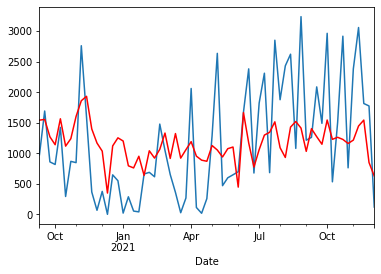

In [131]:
# Nutzung von durchschnitllicher wöchtentlicher Temperatur bzw WindSpeed als exogene Variable
#multivariate = SARIMAX(endog = train_set_weekly["individuals"], exog = train_set_weekly["WS10M_MAX"], order = (2,1,0), seasonal_order=(0,0,0,12))
multivariate = SARIMAX(endog = train_set_weekly["individuals"], exog = exog, order = (3,1,0),seasonal_order=(1,0,1,12), trend= "n", mle_regression = False, enforce_stationarity = False)
multivariate_fit = multivariate.fit(disp=False)
multivariate_fit.summary()
fit_plot_evaluate(multivariate,train_set_weekly["individuals"], test_set_weekly, exogen= exog_test)


In [132]:
exog_test.shape

(65,)

In [133]:
#rolling_forecast(traindata=train_set_weekly["individuals"],test_data = test_set_weekly,Modell_order=(2,1,0), lala=exog_test)

In [134]:
#fit_plot_evaluate(multivariate,train_set_weekly["individuals"], test_set_weekly,exogen = test_set_weekly)


In [135]:
test = SARIMAX(train_set_weekly["individuals"], order = (15,1,0))

(919.6339078520036, 7.270772085282938e+16)

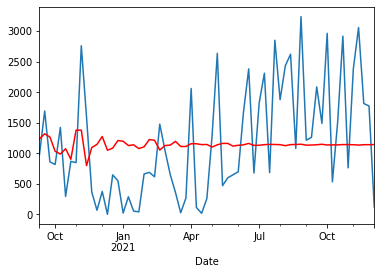

In [136]:
fit_plot_evaluate(test,train_set_weekly["individuals"], test_set_weekly["individuals"])

In [137]:
import itertools
import statsmodels.api as sm

### Define Parameter Ranges to Test ###

# Note: higher numbers will result in code taking much longer to run
# Here we have it set to test p,d,q each = 0, 1 & 2

# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data
# You'll want to change this according to your time series' frequency
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

### Run Grid Search ###

# Note: this code will take a while to run

# Define function
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='W'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic])
                print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    
    return ans_df
    
### Apply function to your time series data ###

# Remember to change frequency to match your time series data
#sarimax_gridsearch(train_set_w, pdq, pdqs, freq='W')

# Statistical Methods to determine the Correlation between Time Series

In [138]:

# Statistical Test to determine if there are correlations between the series Data
#p value > 0.05 --> not Significant
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
       
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(two_feautre_df, variables = combined_df.columns) 

,T2M_x,T2MDEW_x,T2MWET_x,TS_x,T2M_RANGE_x,T2M_MAX_x,T2M_MIN_x,PS_x,WS10M_x,WS10M_MAX_x,WS10M_MIN_x,WS10M_RANGE_x,WD10M_x,WS50M_x,WS50M_MAX_x,WS50M_MIN_x,WS50M_RANGE_x,WD50M_x,individuals_x
T2M_y,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0003,0.0523,0.0280,0.0006,0.0000,0.0000,0.0064,0.0002,0.0026,0.0000,0.0000,0.2246
T2MDEW_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0199,0.0333,0.0000,0.0000,0.0000,0.0950,0.0097,0.0008,0.0000,0.0000,0.0860
T2MWET_y,0.0003,0.0003,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1415,0.1433,0.0060,0.0000,0.0000,0.1053,0.0179,0.0240,0.0000,0.0000,0.5159
TS_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0001,0.0000,0.0005,0.0030,0.0000,0.0000,0.0000,0.0009,0.0000,0.0002,0.0000,0.0000,0.0234
T2M_RANGE_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0260,0.0057,0.0268,0.0000,0.0385,0.0134,0.0051,0.0322,0.0000,0.0354,0.4374
T2M_MAX_y,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0031,0.0168,0.0074,0.0003,0.0000,0.0000,0.0019,0.0000,0.0008,0.0000,0.0000,0.3898
T2M_MIN_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0940,0.0646,0.0019,0.0000,0.0000,0.0787,0.0046,0.0083,0.0000,0.0000,0.4693
PS_y,0.0001,0.0000,0.0000,0.0000,0.0000,0.0001,0.0001,1.0000,0.0000,0.0000,0.0000,0.0115,0.0000,0.0000,0.0000,0.0000,0.0039,0.0000,0.1940
WS10M_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,1.0000,0.0000,0.0001,0.0000,0.0000,0.0004,0.0000,0.0037,0.0000,0.0000,0.5396
WS10M_MAX_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0002,0.0000,1.0000,0.0000,0.0000,0.0000,0.0387,0.0300,0.0000,0.0000,0.0001,0.3048


In [139]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

#cointegration_test(two_feautre_df[["individuals","WS50M_MAX","WS50M_RANGE"]])
cointegration_test(train_set_weekly)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
T2M    ::  1213.1    > nan       =>   False
T2MDEW ::  1063.52   > nan       =>   False
T2MWET ::  927.83    > nan       =>   False
TS     ::  803.59    > nan       =>   False
T2M_RANGE ::  690.72    > nan       =>   False
T2M_MAX ::  591.07    > nan       =>   False
T2M_MIN ::  501.41    > nan       =>   False
PS     ::  417.24    > 311.1288  =>   True
WS10M  ::  340.29    > 263.2603  =>   True
WS10M_MAX ::  279.24    > 219.4051  =>   True
WS10M_MIN ::  225.37    > 179.5199  =>   True
WS10M_RANGE ::  176.32    > 143.6691  =>   True
WD10M  ::  140.97    > 111.7797  =>   True
WS50M  ::  106.06    > 83.9383   =>   True
WS50M_MAX ::  73.83     > 60.0627   =>   True
WS50M_MIN ::  45.27     > 40.1749   =>   True
WS50M_RANGE ::  21.65     > 24.2761   =>   False
WD50M  ::  4.21      > 12.3212   =>   False
individuals ::  0.01      > 4.1296    =>   False


C:\Users\hornd\AppData\Local\R-MINI~1\lib\site-packages\statsmodels\tsa\vector_ar\vecm.py:577: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  warnings.warn("Critical values are only available for time series "


In [140]:
co = coint_johansen(two_feautre_df[["individuals","WS50M_MAX","WS50M_RANGE"]],1,1)

In [141]:
#print(np.linalg.eigvalsh(two_feautre_df))


In [142]:
from matplotlib import pyplot


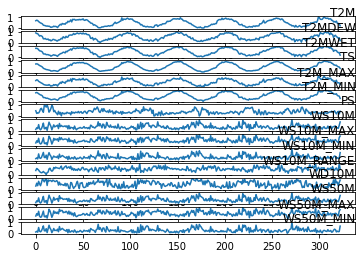

In [143]:
values = combined_df.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7,8,9,10,11,12,13,14,15]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(combined_df.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

# Vector Autoregressiv

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [145]:
train_set_weekly = train_set_weekly.diff()[1:]


In [146]:
train_set_weekly = train_set_weekly.dropna()


In [147]:
train_set_weekly

,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,PS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WD10M,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,WD50M,individuals
Date,,,,,,,,,,,,,,,,,,,
2015-10-11,0.050841,-0.054019,-0.000212,0.011597,0.131881,0.072786,0.027721,-0.241213,0.149325,0.191392,0.068523,0.183479,0.258295,0.166218,0.210411,0.061924,0.193017,0.275283,3421.0
2015-10-18,-0.036019,-0.008526,-0.024376,-0.019208,0.000798,-0.032841,-0.043230,0.042765,-0.081562,-0.128463,-0.089561,-0.064337,-0.225711,-0.084118,-0.136259,-0.078914,-0.076893,-0.218177,-2947.0
2015-10-25,-0.092620,-0.110434,-0.108421,-0.071686,-0.136429,-0.107808,-0.071318,-0.002343,0.364473,0.357315,0.447606,-0.082870,0.396704,0.349428,0.353537,0.421721,-0.069047,0.388174,392.0
2015-11-01,-0.057830,-0.110110,-0.089378,-0.056766,-0.030637,-0.053530,-0.054384,0.130639,-0.377555,-0.414575,-0.353637,-0.123114,-0.229266,-0.383412,-0.444990,-0.332487,-0.157709,-0.222137,-134.0
2015-11-08,-0.067967,0.040032,-0.016504,-0.039016,-0.050423,-0.061818,-0.054628,0.234329,-0.088716,-0.100948,-0.051493,-0.076781,-0.168121,-0.087315,-0.095289,-0.056526,-0.052570,-0.177233,190.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-09,-0.010214,-0.005278,-0.008464,0.002487,-0.170097,-0.039384,0.035171,-0.096661,0.081766,0.084030,0.064716,0.033625,0.224199,0.064098,0.034832,0.084789,-0.060416,0.230530,-1910.0
2020-08-16,0.051455,0.020625,0.039187,0.026153,0.198500,0.084502,0.009118,0.075571,0.015944,0.077524,-0.043278,0.168388,-0.282600,0.040545,0.161424,-0.049540,0.268341,-0.279594,703.0
2020-08-23,0.011597,0.048559,0.031570,0.017664,-0.018191,0.006730,0.018237,-0.056825,-0.058258,-0.075293,-0.004208,-0.101138,0.100875,-0.060061,-0.088538,0.003334,-0.117693,0.097299,413.0


In [148]:
var_model = VAR(train_set_weekly[["individuals","WS50M","WS50M_MAX"]])

In [149]:
results_var = var_model.fit(2)
results_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 30, Dec, 2021
Time:                     14:59:15
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    6.57286
Nobs:                     255.000    HQIC:                   6.39853
Log likelihood:          -1865.34    FPE:                    534.464
AIC:                      6.28122    Det(Omega_mle):         492.759
--------------------------------------------------------------------
Results for equation individuals
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -8.133255       130.903257           -0.062           0.950
L1.individuals        -0.820253         0.060399          -13.580           0.000
L1.WS50M            4230.825299      2158.472547  

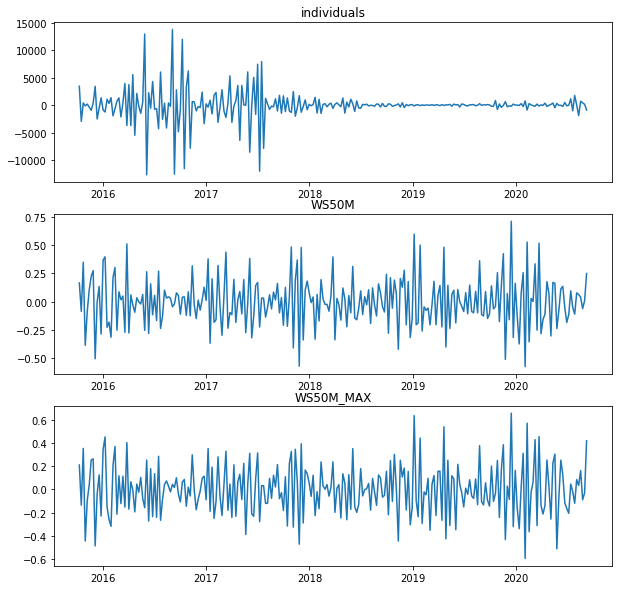

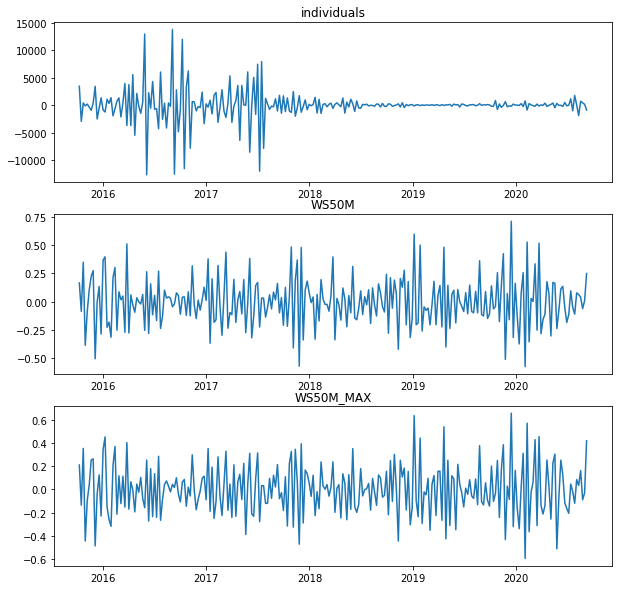

In [150]:
results_var.plot()

In [151]:
print(var_model.select_order(5).summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       7.506       7.548       1819.       7.523
1       6.623       6.791       752.2       6.691
2       6.279      6.574*       533.5       6.398
3       6.202       6.622       493.6       6.371
4       6.076       6.622       435.3      6.295*
5      6.046*       6.719      422.8*       6.317
-------------------------------------------------


In [152]:
results_2 = var_model.fit(maxlags=3, ic='aic')

In [153]:
print(results_2.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 30, Dec, 2021
Time:                     14:59:16
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    6.61480
Nobs:                     254.000    HQIC:                   6.36508
Log likelihood:          -1838.25    FPE:                    491.335
AIC:                      6.19700    Det(Omega_mle):         437.590
--------------------------------------------------------------------
Results for equation individuals
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -5.613062       126.666629           -0.044           0.965
L1.individuals        -0.919956         0.063033          -14.595           0.000
L1.WS50M            4299.515152      2253.537579  

In [154]:
lag_order = results_2.k_ar

In [155]:
results_2.forecast(train_set_weekly[["individuals","WS50M_MAX","WS10M_MAX"]].values[-lag_order:], 3)

array([[ 2.86636289e+02, -2.58049421e-01, -2.75973878e-01],
       [ 7.66720778e+02, -6.66043765e-03, -8.99560669e-04],
       [-4.55496922e+02,  5.25188166e-02,  3.56681485e-02]])

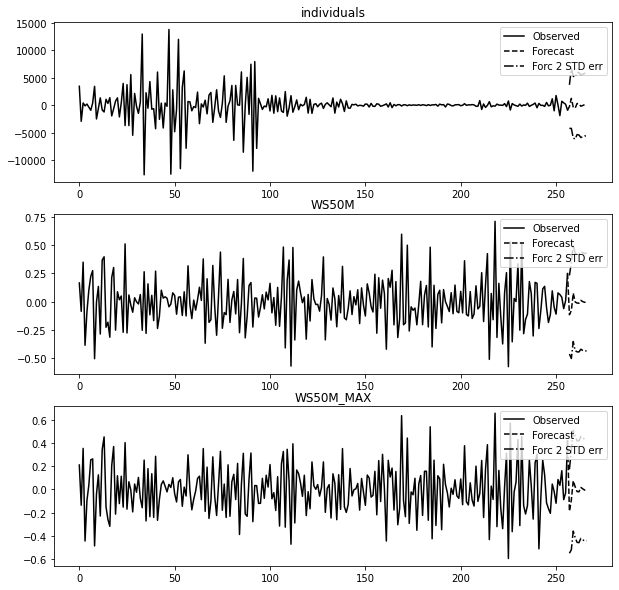

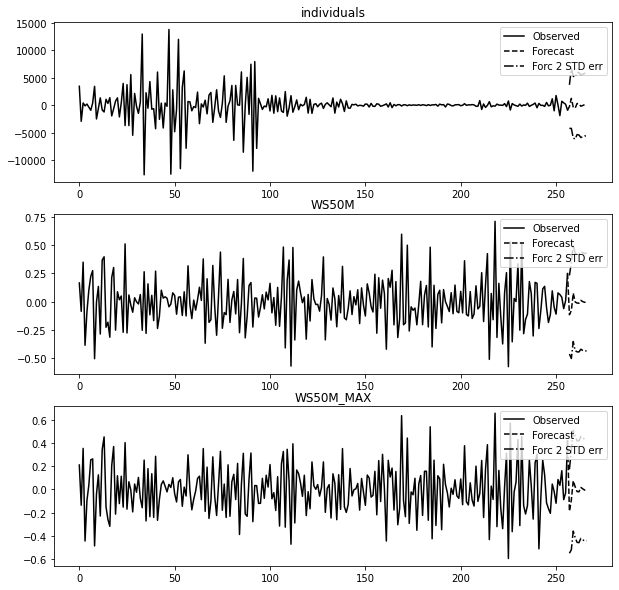

In [156]:
results_2.plot_forecast(10)

# Deep Learning Preparation

In [157]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [158]:
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])

In [159]:
values = values.astype('float32')


In [160]:
reframed = series_to_supervised(combined_df, 1, 1)

In [161]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t)
Date,,,,,,,,,,,,,,,,,,,,,
2015-10-11,0.656862,0.877487,0.808929,0.721467,0.156774,0.546582,0.768094,0.470269,0.110282,0.211842,...,0.403235,0.185534,0.552025,0.546535,0.280114,0.441000,0.175294,0.508435,0.545413,3954
2015-10-18,0.707703,0.823467,0.808718,0.733065,0.288655,0.619368,0.795815,0.229057,0.259608,0.403235,...,0.274772,0.095973,0.487689,0.320824,0.195996,0.304741,0.096380,0.431542,0.327236,1007
2015-10-25,0.671684,0.814941,0.784342,0.713857,0.289453,0.586527,0.752585,0.271822,0.178046,0.274772,...,0.632088,0.543578,0.404819,0.717527,0.545424,0.658278,0.518101,0.362495,0.715410,1399
2015-11-01,0.579065,0.704507,0.675920,0.642171,0.153024,0.478719,0.681267,0.269479,0.542518,0.632088,...,0.217513,0.189942,0.281705,0.488261,0.162012,0.213288,0.185614,0.204786,0.493273,1265
2015-11-08,0.521235,0.594397,0.586543,0.585406,0.122387,0.425189,0.626883,0.400117,0.164963,0.217513,...,0.116564,0.138449,0.204925,0.320141,0.074697,0.117999,0.129089,0.152217,0.316040,1455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-07,0.525459,0.668859,0.627507,0.591236,0.131004,0.431233,0.630465,0.319859,0.421096,0.511805,...,0.384830,0.127429,0.601271,0.577981,0.328735,0.444069,0.121785,0.578462,0.573454,2380
2021-11-14,0.625221,0.543890,0.617605,0.610873,0.407372,0.580046,0.683791,0.186292,0.284546,0.384830,...,0.312326,0.199960,0.403230,0.650535,0.224092,0.300905,0.189425,0.311102,0.648302,3058
2021-11-21,0.423009,0.496062,0.481337,0.509089,0.090793,0.337135,0.528291,0.324546,0.235895,0.312326,...,0.229782,0.144260,0.359809,0.314409,0.207436,0.240908,0.141156,0.295018,0.311977,1814


# Multivaraite Forecasting using Neuronal Networks

In [162]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [163]:
"""
model = Sequential()
model.add(LSTM(100, input_shape=(train_set_weekly["individuals"], train_set_weekly["individuals"])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(train_set_weekly["individuals"], train_set_weekly["individuals"], epochs=20, batch_size=70, validation_data=(test_set_weekly["individuals"], test_set_weekly["individuals"]), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()
"""

'\nmodel = Sequential()\nmodel.add(LSTM(100, input_shape=(train_set_weekly["individuals"], train_set_weekly["individuals"])))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(1))\nmodel.compile(loss=\'mean_squared_error\', optimizer=\'adam\')\n\nhistory = model.fit(train_set_weekly["individuals"], train_set_weekly["individuals"], epochs=20, batch_size=70, validation_data=(test_set_weekly["individuals"], test_set_weekly["individuals"]), \n                    callbacks=[EarlyStopping(monitor=\'val_loss\', patience=10)], verbose=1, shuffle=False)\n\nmodel.summary()\n'

In [164]:
 import pandas as pd
 import numpy as np
 import matplotlib.pyplot as plt
 import plotly.express as px # to plot the time series plot
 from sklearn import metrics # for the evaluation
 from sklearn.preprocessing import LabelEncoder,MinMaxScaler
 from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
 import tensorflow as tf 

In [165]:
print(np.__version__)

1.18.5


In [166]:
#
# !pip install numpy==1.18.5

In [167]:
train_set_weekly

,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,PS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WD10M,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,WD50M,individuals
Date,,,,,,,,,,,,,,,,,,,
2015-10-11,0.0508,-0.0540,-0.0002,0.0116,0.1319,0.0728,0.0277,-0.2412,0.1493,0.1914,0.0685,0.1835,0.2583,0.1662,0.2104,0.0619,0.1930,0.2753,3421.0000
2015-10-18,-0.0360,-0.0085,-0.0244,-0.0192,0.0008,-0.0328,-0.0432,0.0428,-0.0816,-0.1285,-0.0896,-0.0643,-0.2257,-0.0841,-0.1363,-0.0789,-0.0769,-0.2182,-2947.0000
2015-10-25,-0.0926,-0.1104,-0.1084,-0.0717,-0.1364,-0.1078,-0.0713,-0.0023,0.3645,0.3573,0.4476,-0.0829,0.3967,0.3494,0.3535,0.4217,-0.0690,0.3882,392.0000
2015-11-01,-0.0578,-0.1101,-0.0894,-0.0568,-0.0306,-0.0535,-0.0544,0.1306,-0.3776,-0.4146,-0.3536,-0.1231,-0.2293,-0.3834,-0.4450,-0.3325,-0.1577,-0.2221,-134.0000
2015-11-08,-0.0680,0.0400,-0.0165,-0.0390,-0.0504,-0.0618,-0.0546,0.2343,-0.0887,-0.1009,-0.0515,-0.0768,-0.1681,-0.0873,-0.0953,-0.0565,-0.0526,-0.1772,190.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-09,-0.0102,-0.0053,-0.0085,0.0025,-0.1701,-0.0394,0.0352,-0.0967,0.0818,0.0840,0.0647,0.0336,0.2242,0.0641,0.0348,0.0848,-0.0604,0.2305,-1910.0000
2020-08-16,0.0515,0.0206,0.0392,0.0262,0.1985,0.0845,0.0091,0.0756,0.0159,0.0775,-0.0433,0.1684,-0.2826,0.0405,0.1614,-0.0495,0.2683,-0.2796,703.0000
2020-08-23,0.0116,0.0486,0.0316,0.0177,-0.0182,0.0067,0.0182,-0.0568,-0.0583,-0.0753,-0.0042,-0.1011,0.1009,-0.0601,-0.0885,0.0033,-0.1177,0.0973,413.0000


# Dataloading

# Data pre-processing for LSTM

# Creating the Model

In [168]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.layers import Dropout
from keras.optimizers import Adam

In [169]:
print(keras.__version__) 

2.4.3


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

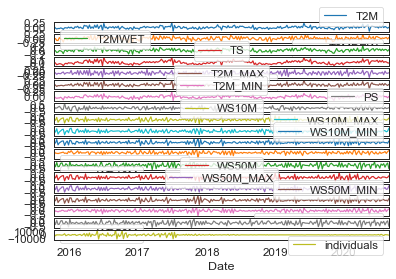

In [170]:
train_set_weekly.plot(subplots=True)


In [171]:
dataset = train_set_weekly.values
train_split = 50
data_mean = dataset[:train_split].mean(axis =0)

data_std = dataset[:train_split].std(axis = 0)

dataset = (dataset - data_mean)/data_std

In [172]:
dataset


array([[ 0.62032259, -0.70119269, -0.0306112 , ...,  1.338267  ,
         1.13417105,  0.75348206],
       [-0.51489123, -0.10885215, -0.40298007, ..., -0.58199599,
        -0.89278129, -0.69480462],
       [-1.25463711, -1.43573723, -1.69811943, ..., -0.52617439,
         1.59788661,  0.06459068],
       ...,
       [ 0.10741873,  0.63441495,  0.4591419 , ..., -0.8722683 ,
         0.40308035,  0.06936675],
       [-0.61626754, -0.41546305, -0.6560083 , ...,  0.69631862,
         1.26594347,  0.00977957],
       [ 0.0712846 ,  0.66613332,  0.45783763, ...,  1.72343603,
        -2.06560061, -0.22811425]])

In [173]:
def mutlivariate_data(dataset , target , start_idx , end_idx , history_size , target_size,
                      step ,  single_step = False):
  data = []
  labels = []
  start_idx = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx ):
    idxs = range(i-history_size, i, step) ### using step
    data.append(dataset[idxs])
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data) , np.array(labels)

In [174]:
history = 20
future_target = 30
STEP = 1

x_train_ss , y_train_ss = mutlivariate_data(dataset , dataset[:, 1], 0, train_split, history,
                                            future_target, STEP , single_step = True)

x_val_ss , y_val_ss = mutlivariate_data(dataset , dataset[:,1] , train_split , None , history ,
                                        future_target, STEP, single_step = True)

print(x_train_ss.shape , y_train_ss.shape)

(30, 20, 19) (30,)


In [175]:
batch_size = 256
buffer_size = 10000

train_ss = tf.data.Dataset.from_tensor_slices((x_train_ss, y_train_ss))
train_ss = train_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_ss = tf.data.Dataset.from_tensor_slices((x_val_ss, y_val_ss))
val_ss = val_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_ss)
print(val_ss)

<RepeatDataset shapes: ((None, 20, 19), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 20, 19), (None,)), types: (tf.float64, tf.float64)>


In [176]:
steps = 200

EPOCHS =10


In [177]:
single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.LSTM(32, input_shape = x_train_ss.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mae')
single_step_model_history = single_step_model.fit(train_ss, epochs = EPOCHS , 
                                                  steps_per_epoch =steps, validation_data = val_ss,
                                                  validation_steps = 50)

Epoch 1/10
200/200 [==============================] - 2s 6ms/step - loss: 0.6898 - val_loss: 1.0009
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0602 - val_loss: 1.0364
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0098 - val_loss: 1.0328
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0067 - val_loss: 1.0284
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0070 - val_loss: 1.0249
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0069 - val_loss: 1.0226
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0059 - val_loss: 1.0207
Epoch 8/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0064 - val_loss: 1.0175
Epoch 9/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0053 - val_loss: 1.0166
Epoch 10/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 1.0140

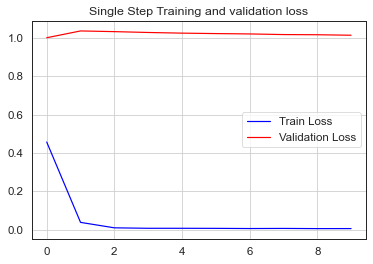

In [178]:
## plot train test loss 

def plot_loss(history , title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss , 'b' , label = 'Train Loss')
  plt.plot(epochs, val_loss , 'r' , label = 'Validation Loss')
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.show()

plot_loss(single_step_model_history , 'Single Step Training and validation loss')

In [179]:
def plot_time_series(plot_data, delta , title):
  labels = ["History" , 'True Future' , 'Model Predcited']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step')
  return plt

In [180]:

### fucntion to create time steps
def create_time_steps(length):
  return list(range(-length,0))

### function to plot time series data

def plot_time_series(plot_data, delta , title):
  labels = ["History" , 'True Future' , 'Model Predcited']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step')
  return plt

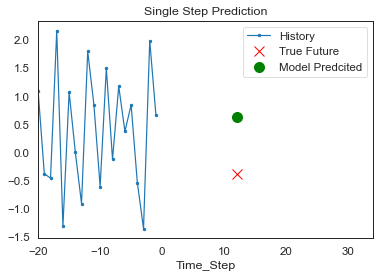

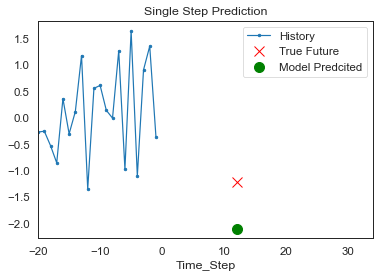

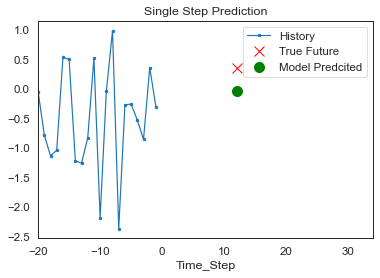

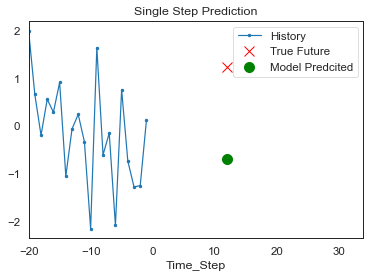

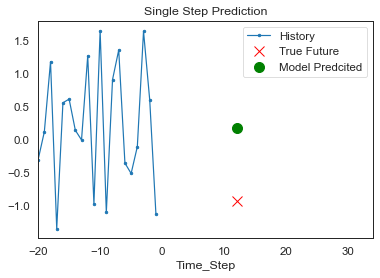

In [181]:
for x, y in val_ss.take(5):
  plot = plot_time_series([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [182]:
future_target = 72 # 72 future values
x_train_multi, y_train_multi = mutlivariate_data(dataset, dataset[:, 1], 0,
                                                 train_split, history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = mutlivariate_data(dataset, dataset[:, 1],
                                             train_split, None, history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)

(30, 20, 19)
(30, 72)


In [183]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

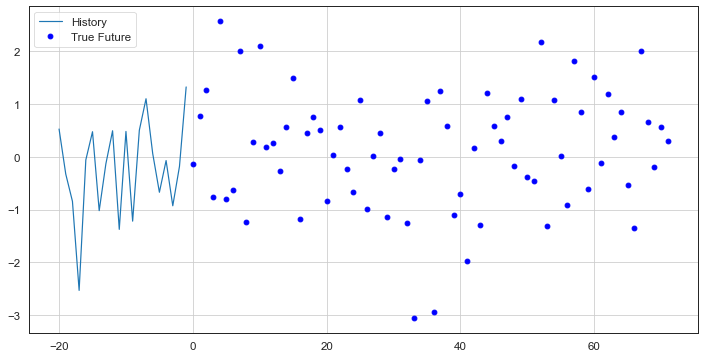

In [184]:

#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  


for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [185]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72)) # for 72 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=steps,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 3s 7ms/step - loss: 0.8276 - val_loss: 0.8331
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.7257 - val_loss: 0.8776
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.6277 - val_loss: 0.8973
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.5496 - val_loss: 0.9261
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4965 - val_loss: 0.9273
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4600 - val_loss: 0.9380
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4305 - val_loss: 0.9529
Epoch 8/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4064 - val_loss: 0.9645
Epoch 9/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3879 - val_loss: 0.9834
Epoch 10/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3725 - val_loss: 0.9885

In [ ]:
results = model.fit(10)
lagged_Values = var_test.values

pred = results.forecast(y=lagged_Values, steps=len(var_test)) 

idx = pd.date_range("2020-09-13", periods=len(var_test), freq='W')
df_forecast = pd.DataFrame(index = idx, data = pred, columns=list(var_test.columns))

df_forecast

In [ ]:
df_forecast["individuals_forecast"] = (combined_df_w["individuals"].iloc[len(var_test)]-combined_df_w["individuals"].iloc[-len(var_test)]) + df_forecast["individuals"].cumsum()
df_forecast["individuals"] = combined_df_w["individuals"]
df_forecast["individuals_forecast"] = df_forecast["individuals_forecast"].apply(lambda x : x if x > 0 else 0)



In [ ]:
df_forecast["predicted"] = inv_diff(var_test["individuals"],df_forecast["individuals"], periods=1)

In [ ]:

test_set_weekly_multi["individuals"].plot(xlabel= "Date", ylabel= "individuals", legend= "individuals")
df_forecast["predicted"].plot(color ="red", legend = "predicted")